#### Basic Info
- [Site Info]( https://www.stathletes.com/big-data-cup/)
-[Github Repository](https://github.com/bigdatacup/Big-Data-Cup-2021)
-[Hockey Graphs Inspo](https://hockey-graphs.com/category/passing-data/)

## Plans/Ideas

### Zone Entry and Scoring Chances
1. Code scoring chance and high danger scoring chance function
2. Generate new chunk function to determine what happens in the chunk after a zone entry
3. For different projects
  - Erie 
    - Compare Otter's performance against teams that are good at defending certain types of zone entries
  - NWHL
    - can rank efficencies across the league

### Breakouts
Analyze different breakout patterns across teams. See where passes originate from. Can help with forecheck and defense

### Player ratings based on sequence efficency

### Good or Bad Penalties
Is it better to take a penalty or a high danger chance





# Putting it all together

1. There's no significant difference betweeen the `xG` on lateral and low to high passes either on the Power Play or at Even Strength
2. Lateral passes are completed less often than low to high passes, so with a similar `xG`, low to high passes are more effective.
3. Excluding shots that come off of zero, many of which are likely rebounds, the `xG` increases in direct relation to the number of passes attempted prior to the goal
  - This is only true up until a certain point (~ 4 passes), where more passes before a shot lead to a lower `xG`
4. Though the average `xG` are similar for lateral and low to high passes, the `xG` steadily decreases per extra lateral or low to high pass attempted.


In [1]:
# bread and butter libraries
import numpy as np
import pandas as pd

# Load Data

In [2]:
erie = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv")

# make column names better
erie.columns = ['gameDate', 'home', 'away', 'period', 'clock',
       'homeSkaters', 'awaySkaters', 'homeGoals',
       'awayGoals', 'team', 'player', 'event', 'X',
       'Y', 'd1', 'd2', 'd3', 'd4',
       'player2', 'X2', 'Y2']

# scale coordinates to be aligned with the NHL, center ice is (0,0)
erie['Y'] = erie['Y'] - 42.5
erie['X'] = erie['X'] - 100
erie['Y2'] = erie['Y2'] - 42.5
erie['X2'] = erie['X2'] - 100
erie

gameDate         home            away  ...          player2    X2    Y2
0      2019-09-20  Erie Otters  Sudbury Wolves  ...  Connor Lockhart   NaN   NaN
1      2019-09-20  Erie Otters  Sudbury Wolves  ...              NaN   NaN   NaN
2      2019-09-20  Erie Otters  Sudbury Wolves  ...     Blake Murray -26.0  -7.5
3      2019-09-20  Erie Otters  Sudbury Wolves  ...              NaN   NaN   NaN
4      2019-09-20  Erie Otters  Sudbury Wolves  ...  Connor Lockhart  -6.0   3.5
...           ...          ...             ...  ...              ...   ...   ...
75868  2020-03-08  Erie Otters  Saginaw Spirit  ...              NaN   NaN   NaN
75869  2020-03-08  Erie Otters  Saginaw Spirit  ...    Hayden Fowler  90.0 -28.5
75870  2020-03-08  Erie Otters  Saginaw Spirit  ...      Maxim Golod  38.0 -16.5
75871  2020-03-08  Erie Otters  Saginaw Spirit  ...              NaN   NaN   NaN
75872  2020-03-08  Erie Otters  Saginaw Spirit  ...              NaN   NaN   NaN

[75873 rows x 21 columns]

In [3]:
olympic = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv")
olympic.columns = ['gameDate', 'home', 'away', 'period', 'clock',
       'homeSkaters', 'awaySkaters', 'homeGoals',
       'awayGoals', 'team', 'player', 'event', 'X',
       'Y', 'd1', 'd2', 'd3', 'd4',
       'player2', 'X2', 'Y2']
olympic

gameDate                       home  ...     X2    Y2
0      2018-02-11   Olympic (Women) - Canada  ...    NaN   NaN
1      2018-02-11   Olympic (Women) - Canada  ...    NaN   NaN
2      2018-02-11   Olympic (Women) - Canada  ...    NaN   NaN
3      2018-02-11   Olympic (Women) - Canada  ...    NaN   NaN
4      2018-02-11   Olympic (Women) - Canada  ...    NaN   NaN
...           ...                        ...  ...    ...   ...
23997  2019-04-14  Olympic (Women) - Finland  ...  132.0  62.0
23998  2019-04-14  Olympic (Women) - Finland  ...  146.0  28.0
23999  2019-04-14  Olympic (Women) - Finland  ...  173.0  63.0
24000  2019-04-14  Olympic (Women) - Finland  ...  181.0  43.0
24001  2019-04-14  Olympic (Women) - Finland  ...    NaN   NaN

[24002 rows x 21 columns]

In [4]:
nwhl = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_nwhl.csv")
nwhl.columns = ['gameDate', 'home', 'away', 'period', 'clock',
       'homeSkaters', 'awaySkaters', 'homeGoals',
       'awayGoals', 'team', 'player', 'event', 'X',
       'Y', 'd1', 'd2', 'd3', 'd4',
       'player2', 'X2', 'Y2']
nwhl

gameDate                 home  ...     X2    Y2
0      2021-01-23  Minnesota Whitecaps  ...    NaN   NaN
1      2021-01-23  Minnesota Whitecaps  ...    NaN   NaN
2      2021-01-23  Minnesota Whitecaps  ...    NaN   NaN
3      2021-01-23  Minnesota Whitecaps  ...    NaN   NaN
4      2021-01-23  Minnesota Whitecaps  ...    NaN   NaN
...           ...                  ...  ...    ...   ...
26877  2021-02-01       Buffalo Beauts  ...    NaN   NaN
26878  2021-02-01       Buffalo Beauts  ...   29.0  82.0
26879  2021-02-01       Buffalo Beauts  ...    NaN   NaN
26880  2021-02-01       Buffalo Beauts  ...    NaN   NaN
26881  2021-02-01       Buffalo Beauts  ...  155.0   6.0

[26882 rows x 21 columns]

## Classification Functions

### Plot Ice

In [5]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

def plotIce():
  """
  This function plots an NHL size sheet of Ice
  """
  img = mpimg.imread('https://raw.githubusercontent.com/benbrill/Big-Data-Cup-2021/main/full_ice.png')
  fig, ax = plt.subplots(figsize=(15,20))
  imgplot = ax.imshow(img, extent=[-100,100,-42.5,42.5])

  highDang = np.array([(-89,-9),(-69,-22),(-54,-22),(-54,-9),(-44,-9),(-44,9),(-54,9),(-54,22),(-69,22),(-89,9),(-69,9),(-69,-9)])

  circ = plt.Rectangle((69,-9), 20, 18, color="red", alpha = 0.3)
  tri = plt.Polygon(highDang*-1, color = "yellow", alpha=0.3)
  fig.gca().add_patch(circ)
  fig.gca().add_patch(tri)
  # plt.axis(False)
  return fig, ax

### High Danger


#### Polygon Function

In [6]:
# function is from geeksforgeeks

INT_MAX = 10000
 
# Given three colinear points p, q, r,  
# the function checks if point q lies 
# on line segment 'pr' 
def onSegment(p:tuple, q:tuple, r:tuple) -> bool:
     
    if ((q[0] <= max(p[0], r[0])) &
        (q[0] >= min(p[0], r[0])) &
        (q[1] <= max(p[1], r[1])) &
        (q[1] >= min(p[1], r[1]))):
        return True
         
    return False
 
# To find orientation of ordered triplet (p, q, r). 
# The function returns following values 
# 0 --> p, q and r are colinear 
# 1 --> Clockwise 
# 2 --> Counterclockwise 
def orientation(p:tuple, q:tuple, r:tuple) -> int:
     
    val = (((q[1] - p[1]) *
            (r[0] - q[0])) -
           ((q[0] - p[0]) *
            (r[1] - q[1])))
            
    if val == 0:
        return 0
    if val > 0:
        return 1 # Collinear
    else:
        return 2 # Clock or counterclock
 
def doIntersect(p1, q1, p2, q2):
     
    # Find the four orientations needed for  
    # general and special cases 
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
 
    # General case
    if (o1 != o2) and (o3 != o4):
        return True
     
    # Special Cases 
    # p1, q1 and p2 are colinear and 
    # p2 lies on segment p1q1 
    if (o1 == 0) and (onSegment(p1, p2, q1)):
        return True
 
    # p1, q1 and p2 are colinear and 
    # q2 lies on segment p1q1 
    if (o2 == 0) and (onSegment(p1, q2, q1)):
        return True
 
    # p2, q2 and p1 are colinear and 
    # p1 lies on segment p2q2 
    if (o3 == 0) and (onSegment(p2, p1, q2)):
        return True
 
    # p2, q2 and q1 are colinear and 
    # q1 lies on segment p2q2 
    if (o4 == 0) and (onSegment(p2, q1, q2)):
        return True
 
    return False
 
# Returns true if the point p lies  
# inside the polygon[] with n vertices 
def is_inside_polygon(points:list, p:tuple) -> bool:
     
    n = len(points)
     
    # There must be at least 3 vertices
    # in polygon
    if n < 3:
        return False
         
    # Create a point for line segment
    # from p to infinite
    extreme = (INT_MAX, p[1])
    count = i = 0
     
    while True:
        next = (i + 1) % n
         
        # Check if the line segment from 'p' to  
        # 'extreme' intersects with the line  
        # segment from 'polygon[i]' to 'polygon[next]' 
        if (doIntersect(points[i],
                        points[next], 
                        p, extreme)):
                             
            # If the point 'p' is colinear with line  
            # segment 'i-next', then check if it lies  
            # on segment. If it lies, return true, otherwise false 
            if orientation(points[i], p, 
                           points[next]) == 0:
                return onSegment(points[i], p, 
                                 points[next])
                                  
            count += 1
             
        i = next
         
        if (i == 0):
            break
         
    # Return true if count is odd, false otherwise 
    return (count % 2 == 1)
# This code is contributed by Vikas Chitturi

### High Danger Function

In [7]:
def timetoSecs(t): 
  new = t.split(":")
  if ((int(new[1]) == 0) & (int(new[0]) == 0)):
    new = 0
  elif int(new[1]) == 0:
    new = int(new[0].lstrip('0'))*60
  elif int(new[0]) == 0:
    new = int(new[1].lstrip('0'))
  else:
    new = int(new[0].lstrip('0'))*60 + int(new[1].lstrip('0'))
  return new

In [8]:
def isHighDanger(x, y, ax, df):
  '''
  inputs x and y coordinates of a data frame that contains only shots and goals, 
  '''
  try:
    point = (x,y)
    score = 0
    highDang = np.array([(-89,-9),(-69,-22),(-54,-22),(-54,-9),(-44,-9),(-44,9),(-54,9),(-54,22),(-69,22),(-89,9),(-69,9),(-69,-9)])
    #find initial score based on shot location
    if is_inside_polygon(highDang*-1, point):
      score += 2
    elif is_inside_polygon([(69, -9), (69, 9), (89, 9), (89, -9)], point):
      score+= 3
    else:
      score+= 1
    # add halfpoints for traffic and for one timers

    time = timetoSecs(df.loc[ax, "clock"])
    team = df.loc[ax, "team"]

    index = ax-1
    time1 = time
    reboundFlag, rushFlag = False, False
    while (time1 < time + 4):
      # print(f"Orig time: {time}, current time: {time1}, index: {index}, og time: {df.loc[ax, 'clock']} ")
      time1 = timetoSecs(df.loc[index, "clock"])
      currentEvent = df.loc[index, "event"]
      currentTeam = df.loc[index, "team"]

      # check for rebounds
      if (currentTeam == team and reboundFlag != True):
        if (currentEvent == "Shot" or currentEvent == "Goal"):
          score += 1
          df.loc[ax, 'isRebound'] = 1
          reboundFlag = True
      
      #check for rush
      # print(df.loc[index, "X"])
      if ((df.loc[index, "X"] <= 24) and rushFlag != True):
        score += 1
        df.loc[ax, 'isRush'] = 1
        rushFlag = True
    
      # stop if either rebound and rush is True, exhausting all possibilities
      if reboundFlag and rushFlag:
        break
      
      index = index - 1
  except KeyError:
    return 0
  return score

### Determine HighLow or Lateral

In [9]:
def isLat(X, Y, X2, Y2):
  if ((X >= 54) & (Y <= -22) | (Y >= 22)) & ((X2 >= 54) & (Y2 <= -22) | (Y2 >= 22)) & (X >= 54):
    return 1
  else:
    return 0
def isLowHigh(X, Y, X2, Y2):
  if ((X2 <= 44) & (X2 >= 24)) & (X >= 69):
    return 1
  else:
    return 0

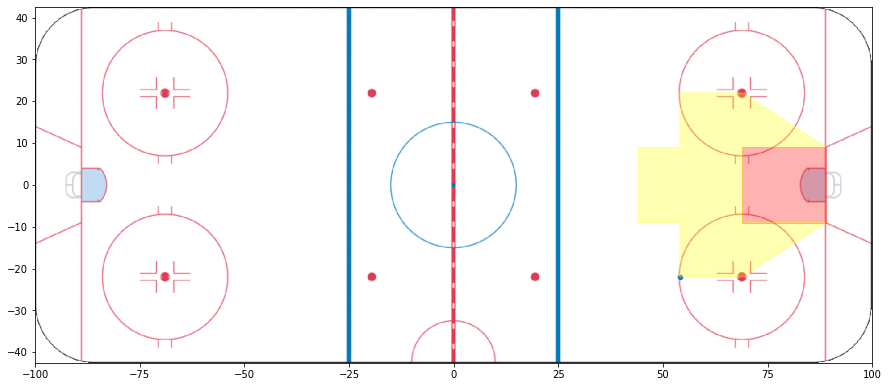

In [10]:
fig, ax = plotIce()
sns.scatterplot(x=[54], y = [-22], ax = ax)

### Seperate Chunks

In [11]:
def seperateChunks(df):
  print("Staring")
  sequences = []
  seq = []
  team = df.iloc[0]["team"]

  # establish empty chunkCount column

  df['chunk'], df['chunkIdx'] = np.NaN, np.NaN
  maxlen = 0
  chunkCount = 0
  itercount = 0
  # print(team)
  for index, rows in df.iterrows():
    # print(index, chunkCount)
    # print(team, rows["team"])
    if ((team != rows["team"]) | (rows['event'] == 'Faceoff Win')):
      # print("row is different team")
      sequences.append(seq)
      chunkCount += 1
      itercount = 0
      seq = []
    if len(seq) == 0:
      # print("establish new team")
      team = rows["team"]
    if team == rows["team"]:
      # print("row is same team")
      seq.append(rows.to_numpy())
    df.loc[index,'chunk'] = chunkCount
    df.loc[index,'chunkIdx'] = itercount
    itercount += 1
  return toArray(sequences) # for LTSM
  # return np.asarray(sequences, dtype=object)

def toArray(seq):
  holla = seq
  maxlen = 0
  for i in seq:
    if len(i) > maxlen:
      maxlen = len(i)
  counter = 0
  for i in holla:
    if len(i) < maxlen:
      holla[counter] = i + [[0 for i in range(21)]]*(maxlen-len(i))
    counter += 1
  return np.asarray(holla, dtype=object)

### Map Pass Events

In [12]:
def mapPassEvents(chunk, fig, ax):
  chunk = chunk.fillna(0)
  
  sns.scatterplot(x='X', y = 'Y', data=chunk, style='event', ax=ax, hue='xG', palette='RdBu', s = 300, alpha = 1)
  colors = {
        'Incomplete Play': 'red',
        'Play': 'blue',
        'On Net': 'green',
        'Missed': 'grey',
        'Blocked': 'firebrick'
    }
  tofP = {
      'Direct': '-',
      'Indirect': '-.',
      't': '-.',
      'f' :'--'
    }
  count = 0
  for index, play in chunk.iterrows():
    # if the iteration is the first
    if count == 0:
      count += 1
      continue
    
    # current play is not a pass
    if ((play['event'] != "Play") and (play['event'] != "Incomplete Play")):
      if ((chunk.loc[index-1].event != 'Play') and (chunk.loc[index-1].event != "Incomplete Play")): # play before is not a pass
        if (chunk.loc[index-1].event != 'Shot'):
          nopassArrow(ax, chunk.loc[index-1]['X'], chunk.loc[index-1]['Y'], play['X'], play['Y'], count)
          count += 1
        else: 
          cColor = colors[chunk.loc[index-1]['d2']]
          ctype = tofP[chunk.loc[index-1]['d3']]
          ax.plot([chunk.loc[index-1]['X'], 89], [chunk.loc[index-1]['Y'], 0], color = cColor, linestyle=ctype)
      else: # if the play before is a pass
        ax.arrow(chunk.loc[index-1]['X2'], chunk.loc[index-1]['Y2'], (play['X'] - chunk.loc[index-1]['X2']), (play['Y'] - chunk.loc[index-1]['Y2']), 
              head_width=1, linestyle = "-", color = "grey", width=0.5, alpha = 0.15,)
        midpointX = (play['X'] + chunk.loc[index-1]['X2']) / 2
        midpointY = (play['Y'] + chunk.loc[index-1]['Y2']) / 2
        ax.annotate(count, (midpointX, midpointY),)
        count += 1


    if (play['event'] == "Play") or (play['event'] == "Incomplete Play"): # if current play is a pass
      if (((chunk.loc[index-1].event == 'Play') or (chunk.loc[index-1].event == "Incomplete Play"))): # if the play before is also a pass
        nopassArrow(ax, chunk.loc[index-1]['X2'], chunk.loc[index-1]['Y2'], play['X'], play['Y'], count)
        count += 1
      else: #if current play is a pass and play before is not a pass
        nopassArrow(ax, chunk.loc[index-1]['X'], chunk.loc[index-1]['Y'], play['X'], play['Y'], count)
        count += 1

      cColor = colors[play['event']]
      ctype = tofP[play['d1']]
      ax.arrow(play['X'], play['Y'], (play['X2'] - play['X']), (play['Y2'] - play['Y']), head_width=3, linestyle = ctype, color = cColor, width=1, alpha = 0.3,)
      midpointX = (play['X'] + play['X2']) / 2
      midpointY = (play['Y'] + play['Y2']) / 2
      ax.annotate(count, (midpointX, midpointY), color = "red")
      # print(f'play now: {count}, {index}')
      count+= 1
  ax.set_title(f'Team: {play.loc["team"]}')

def nopassArrow(ax, startX, startY, endX, endY, count):
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
              head_width=1, linestyle = "-", color = "grey", width=0.5, alpha = 0.15,)
  midpointX = (startX + endX) / 2
  midpointY = (startY + endY) / 2
  ax.annotate(count, (midpointX, midpointY))

## Transform Data

In [13]:
data = pd.concat((nwhl, olympic)).reset_index()
# data = erie
data['Y'] = data['Y'] - 42.5
data['X'] = data['X'] - 100
data['Y2'] = data['Y2'] - 42.5
data['X2'] = data['X2'] - 100
data['isLat'] = data.apply(lambda x: isLat(x['X'], x['Y'], x['X2'], x['Y2']), axis = 1)
data['isLowHigh'] = data.apply(lambda x: isLowHigh(x['X'], x['Y'], x['X2'], x['Y2']), axis = 1)
data['shotQuality'] = data.loc[(data['event'] == "Shot") | (data['event'] == "Goal")].apply(lambda x: isHighDanger(x['X'],x['Y'], x.name, data), axis = 1)
data

index    gameDate  ... isRebound shotQuality
0          0  2021-01-23  ...       NaN         NaN
1          1  2021-01-23  ...       NaN         NaN
2          2  2021-01-23  ...       NaN         NaN
3          3  2021-01-23  ...       NaN         2.0
4          4  2021-01-23  ...       NaN         NaN
...      ...         ...  ...       ...         ...
50879  23997  2019-04-14  ...       NaN         NaN
50880  23998  2019-04-14  ...       NaN         NaN
50881  23999  2019-04-14  ...       NaN         NaN
50882  24000  2019-04-14  ...       NaN         NaN
50883  24001  2019-04-14  ...       NaN         NaN

[50884 rows x 27 columns]

In [14]:
data.iloc[48]

index                           48
gameDate                2021-01-23
home           Minnesota Whitecaps
away                  Boston Pride
period                           1
clock                        18:26
homeSkaters                      5
awaySkaters                      5
homeGoals                        0
awayGoals                        0
team                  Boston Pride
player                Lauren Kelly
event                         Shot
X                               96
Y                            -22.5
d1                        Snapshot
d2                          On Net
d3                               f
d4                               f
player2                        NaN
X2                             NaN
Y2                             NaN
isLat                            0
isLowHigh                        0
isRush                         NaN
isRebound                      NaN
shotQuality                      1
Name: 48, dtype: object

# Plot Passes

In [15]:
from sklearn.cluster import KMeans

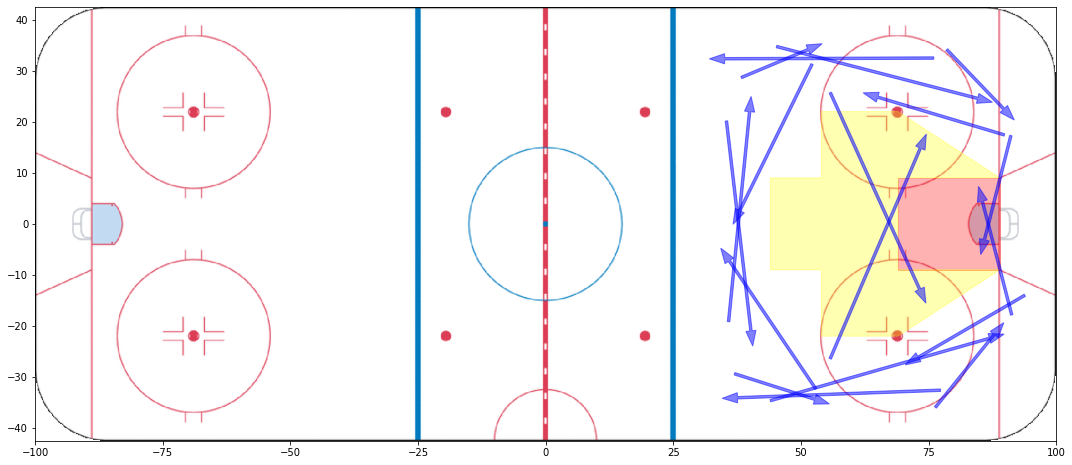

In [16]:
# all passes
Xpasses = data[((data.event == "Play") | (data.event == "Incomplete Play")) & (data.X >= 25) & (data.X2 >=25)][['X', 'Y', 'X2', 'Y2']]
kmeans = KMeans(n_clusters=18, init='k-means++', random_state=6)
kmeans.fit(Xpasses)
graphX = kmeans.cluster_centers_
fig, ax = plotIce()
count = 0
for i in graphX: 
  startX, startY, endX, endY = i[0], i[1], i[2], i[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                head_width=2, linestyle = "-", color = "blue", width=0.5, alpha = 0.5,)
  count +=1
plt.tight_layout()

In [17]:
len(kmeans.labels_)

8653

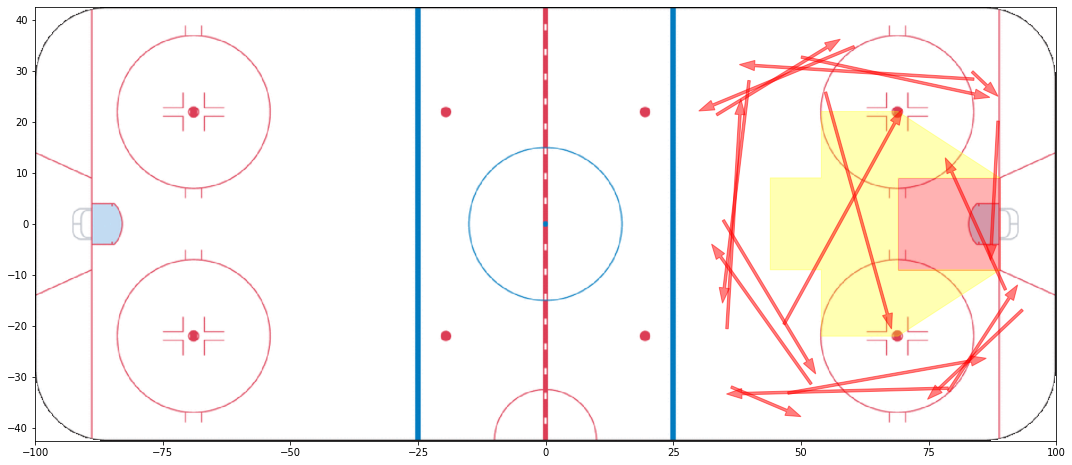

In [18]:
# powerplay passes
XpassesPP = data[((data.event == "Play") | (data.event == "Incomplete Play")) & (data.X >= 25) & (data.X2 >=25) & (data.homeSkaters != data.awaySkaters)][['X', 'Y', 'X2', 'Y2']]
kmeansPP = KMeans(n_clusters=18, init='k-means++', random_state=10)
kmeansPP.fit(XpassesPP)
graphX = kmeansPP.cluster_centers_
fig, ax = plotIce()
for i in graphX: 
  startX, startY, endX, endY = i[0], i[1], i[2], i[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                head_width=2, linestyle = "-", color = "red", width=0.5, alpha = 0.5,)
plt.tight_layout()

In [19]:
XpassesPP['passCluster'] = kmeansPP.labels_
data = data.join(XpassesPP['passCluster'],)
data

index    gameDate  ... shotQuality passCluster
0          0  2021-01-23  ...         NaN         NaN
1          1  2021-01-23  ...         NaN         NaN
2          2  2021-01-23  ...         NaN         NaN
3          3  2021-01-23  ...         2.0         NaN
4          4  2021-01-23  ...         NaN         NaN
...      ...         ...  ...         ...         ...
50879  23997  2019-04-14  ...         NaN         1.0
50880  23998  2019-04-14  ...         NaN         5.0
50881  23999  2019-04-14  ...         NaN         8.0
50882  24000  2019-04-14  ...         NaN         0.0
50883  24001  2019-04-14  ...         NaN         NaN

[50884 rows x 28 columns]

In [20]:
data = pd.get_dummies(data, columns=['passCluster'])
data

index    gameDate  ... passCluster_16.0 passCluster_17.0
0          0  2021-01-23  ...                0                0
1          1  2021-01-23  ...                0                0
2          2  2021-01-23  ...                0                0
3          3  2021-01-23  ...                0                0
4          4  2021-01-23  ...                0                0
...      ...         ...  ...              ...              ...
50879  23997  2019-04-14  ...                0                0
50880  23998  2019-04-14  ...                0                0
50881  23999  2019-04-14  ...                0                0
50882  24000  2019-04-14  ...                0                0
50883  24001  2019-04-14  ...                0                0

[50884 rows x 45 columns]

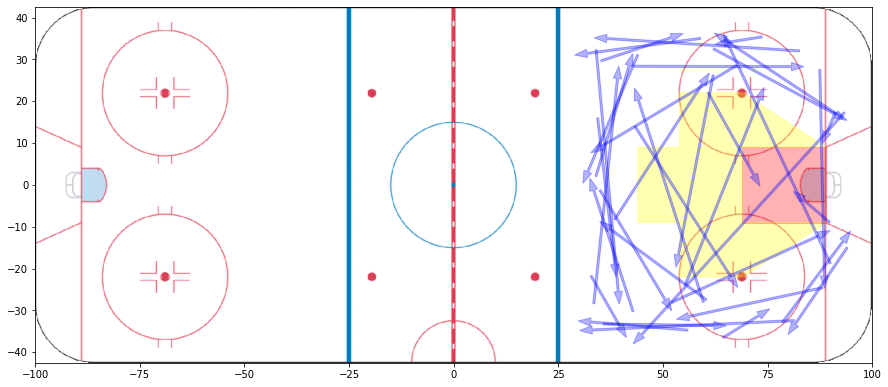

In [21]:
# powerplay passes for erie
Xpasses = erie[(erie.event == "Play") & (erie.X >= 25) & (erie.X2 >=25) & (erie.homeSkaters != erie.awaySkaters)][['X', 'Y', 'X2', 'Y2']]
ekmeans = KMeans(n_clusters=36, init='k-means++')
ekmeans.fit(Xpasses)
graphX = ekmeans.cluster_centers_
fig, ax = plotIce()
for i in graphX: 
  startX, startY, endX, endY = i[0], i[1], i[2], i[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                head_width=2, linestyle = "-", color = "blue", width=0.5, alpha = 0.3,)
# powerplay passes
# Xpasses = data[(data.event == "Play") & (data.X >= 25) & (data.X2 >=25) & (data.homeSkaters != data.awaySkaters)][['X', 'Y', 'X2', 'Y2']]
# kmeans = KMeans(n_clusters=64, init='k-means++')
# kmeans.fit(Xpasses)
# graphX = kmeans.cluster_centers_
# for i in graphX: 
#   startX, startY, endX, endY = i[0], i[1], i[2], i[3]
#   ax.arrow(startX, startY, (endX - startX), (endY - startY), 
#                 head_width=2, linestyle = "-", color = "pink", width=0.5, alpha = 0.6,)

In [22]:
def distance(X,Y):
  return round(np.sqrt((89-X)**2 + (0 - Y)**2), 2)

In [23]:
import math
def shotAngle(X,Y):
  x0 = 89 - X
  return math.degrees(math.atan2(Y, x0))

In [24]:
def timeDiff(clock, series, df):
  idx = series.name
  if idx == 0:
    return 0
  return df.loc[idx - 1, 'clock'] - clock

In [25]:
data

index    gameDate  ... passCluster_16.0 passCluster_17.0
0          0  2021-01-23  ...                0                0
1          1  2021-01-23  ...                0                0
2          2  2021-01-23  ...                0                0
3          3  2021-01-23  ...                0                0
4          4  2021-01-23  ...                0                0
...      ...         ...  ...              ...              ...
50879  23997  2019-04-14  ...                0                0
50880  23998  2019-04-14  ...                0                0
50881  23999  2019-04-14  ...                0                0
50882  24000  2019-04-14  ...                0                0
50883  24001  2019-04-14  ...                0                0

[50884 rows x 45 columns]

In [26]:
passIdx = (data['event'] == "Play") | (data['event'] == "Incomplete Play")
data['passDistance'] = data[passIdx].apply(lambda x: np.sqrt((x['X2'] - x['X'])**2 + (x['Y2'] - x['Y'])**2), axis=1)
data

index    gameDate  ... passCluster_17.0 passDistance
0          0  2021-01-23  ...                0          NaN
1          1  2021-01-23  ...                0          NaN
2          2  2021-01-23  ...                0          NaN
3          3  2021-01-23  ...                0          NaN
4          4  2021-01-23  ...                0          NaN
...      ...         ...  ...              ...          ...
50879  23997  2019-04-14  ...                0    50.159745
50880  23998  2019-04-14  ...                0    22.360680
50881  23999  2019-04-14  ...                0    44.204072
50882  24000  2019-04-14  ...                0    20.124612
50883  24001  2019-04-14  ...                0          NaN

[50884 rows x 46 columns]

## Chunks for passes and goals

In [27]:
xGData = data.copy()
xGData = xGData.drop(['gameDate', 'home', 'away', 'period', 'player', "player2", "X2", "Y2", "homeGoals", "awayGoals"], axis = 1)
xGData['shotDistance'] = xGData[(xGData['event'] == "Shot") | (xGData['event'] == "Goal")].apply(lambda x: distance(x["X"], x['Y']), axis = 1)
xGData['shotAngle'] = xGData[(xGData['event'] == "Shot") | (xGData['event'] == "Goal")].apply(lambda x: shotAngle(x["X"], x['Y']), axis = 1)
xGData['isGoal'] = xGData['event'].apply(lambda x: 1 if (x == "Goal") else 0)
xGData['clock'] = xGData['clock'].apply(timetoSecs)
xGData['timeDiff'] = xGData.apply(lambda x: timeDiff(x['clock'], x, xGData), axis = 1)
xGData # [(xGData['event'] == "Shot") | (xGData['event'] == "Goal")]

index  clock  homeSkaters  ...  shotAngle isGoal timeDiff
0          0   1200            5  ...        NaN      0        0
1          1   1198            5  ...        NaN      0        2
2          2   1197            5  ...        NaN      0        1
3          3   1195            5  ... -14.036243      0        2
4          4   1193            5  ...        NaN      0        2
...      ...    ...          ...  ...        ...    ...      ...
50879  23997      9            4  ...        NaN      0        2
50880  23998      7            4  ...        NaN      0        2
50881  23999      6            4  ...        NaN      0        1
50882  24000      4            4  ...        NaN      0        2
50883  24001      1            4  ...        NaN      0        3

[50884 rows x 40 columns]

In [28]:
def seperatePassShotChunks(df):
  print("Staring")
  sequences = []
  seq = []
  team = df.iloc[0]["team"]

  # establish empty chunkCount column

  df['chunk'], df['chunkIdx'] = np.NaN, np.NaN
  maxlen = 0
  chunkCount = 0
  itercount = 0
  for index, rows in df.iterrows():
    if ((rows["event"] == "Shot") | (rows['event'] == "Goal")): 
      sequences.append(seq)
      df.loc[index,'chunk'] = chunkCount
      df.loc[index,'chunkIdx'] = itercount
      chunkCount += 1
      itercount = 0
      seq = []
      continue
    if ((team != rows["team"])):
      # print("row is different team")
      sequences.append(seq)
      chunkCount += 1
      itercount = 0
      seq = []
    if len(seq) == 0:
      # print("establish new team")
      team = rows["team"]
    if team == rows["team"]:
      # print("row is same team")
      seq.append(rows.to_numpy())
    df.loc[index,'chunk'] = chunkCount
    df.loc[index,'chunkIdx'] = itercount
    itercount += 1
  return toArray(sequences) # for LTSM

In [29]:
passShot = xGData[(xGData['event'] == "Shot") | (xGData['event'] == "Goal") | (xGData['event'] == "Play") | (xGData['event'] == "Incomplete Play")]
seperatePassShotChunks(passShot)

Staring


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


array([[list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        ...,
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
       [list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        ...,
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
       [array([8, 1187, 

In [30]:
# chunks consisting of only passes and shots
passchunks = passShot.reset_index().set_index(['chunk', 'chunkIdx'])
passchunks

level_0  index  clock  ...  shotAngle  isGoal timeDiff
chunk   chunkIdx                         ...                            
0.0     0.0             3      3   1195  ... -14.036243       0        2
2.0     0.0             8      8   1187  ...        NaN       0        1
        1.0             9      9   1183  ...        NaN       0        4
3.0     0.0            11     11   1180  ...        NaN       0        0
4.0     0.0            14     14   1174  ...        NaN       0        2
...                   ...    ...    ...  ...        ...     ...      ...
10387.0 2.0         50876  23994     14  ...  45.567266       0        2
10388.0 0.0         50879  23997      9  ...        NaN       0        2
        1.0         50880  23998      7  ...        NaN       0        2
        2.0         50881  23999      6  ...        NaN       0        1
        3.0         50882  24000      4  ...        NaN       0        2

[24440 rows x 41 columns]

In [31]:
passchunks.loc[(48, 8),:]

level_0                      223
index                        223
clock                        737
homeSkaters                    4
awaySkaters                    5
team                Boston Pride
event                       Shot
X                             66
Y                          -10.5
d1                      Snapshot
d2                        On Net
d3                             t
d4                             f
isLat                          0
isLowHigh                      0
isRush                       NaN
isRebound                    NaN
shotQuality                    2
passCluster_0.0                0
passCluster_1.0                0
passCluster_2.0                0
passCluster_3.0                0
passCluster_4.0                0
passCluster_5.0                0
passCluster_6.0                0
passCluster_7.0                0
passCluster_8.0                0
passCluster_9.0                0
passCluster_10.0               0
passCluster_11.0               0
passCluste

## Score Shots for quality of prior passes

In [32]:
np.unique(np.array(list(zip(*passchunks.index))[0]))

array([0.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.0386e+04, 1.0387e+04,
       1.0388e+04])

In [33]:
def countPassTypes(chunk):
  chas = np.unique(np.array(list(zip(*chunk.index))[0]))
  for index in chas:
    current = chunk.loc[index]
    current = current.fillna(0)

    try:
      shotIdx = int(current.iloc[-1].name)
    except ValueError:
      shotIdx = current.iloc[-1].name
    
    
    realIdx = current.loc[shotIdx, "index"]
    if (data.loc[realIdx, "event"] == "Shot"):
      passchunks.loc[(index, shotIdx), 'isRebound'] = 1
    if current.loc[shotIdx, "event"] != "Shot":
      continue
    if len(current) <= 3:
      subtract = shotIdx - (len(current) - 1)
    else:
      subtract = shotIdx - 3
    # print(current[subtract:shotIdx]['isLowHigh'])
    # find number of low high pass
    passchunks.loc[(index, shotIdx), 'passCount'] = len(current[current.event == "Play"])
    passchunks.loc[(index, shotIdx), 'ozonePassCount'] = len(current[(current.event == "Play") & (current.X >= 25) & (current.X >= 25)])
    passchunks.loc[(index, shotIdx), 'lowHighCount'] = current[subtract:shotIdx]['isLowHigh'].sum()
    passchunks.loc[(index, shotIdx), 'latCount'] = current[subtract:shotIdx]['isLat'].sum()

    passchunks.loc[(index, shotIdx), ["passCluster_0.0",	"passCluster_1.0",
      "passCluster_2.0",	"passCluster_3.0",	"passCluster_4.0",
      "passCluster_5.0",	"passCluster_6.0",	"passCluster_7.0",
      "passCluster_8.0",	"passCluster_9.0",	"passCluster_10.0",
      "passCluster_11.0",	"passCluster_12.0",	"passCluster_13.0",
      "passCluster_14.0",	"passCluster_15.0",	"passCluster_16.0",
      "passCluster_17.0"]]= current[["passCluster_0.0",	"passCluster_1.0",
      "passCluster_2.0",	"passCluster_3.0",	"passCluster_4.0",
      "passCluster_5.0",	"passCluster_6.0",	"passCluster_7.0",
      "passCluster_8.0",	"passCluster_9.0",	"passCluster_10.0",
      "passCluster_11.0",	"passCluster_12.0",	"passCluster_13.0",
      "passCluster_14.0",	"passCluster_15.0",	"passCluster_16.0",
      "passCluster_17.0"]].sum()
    # print(passchunks.loc[(index, shotIdx), 'latCount'])

    # if (current['isLowHigh'].sum() > 0) | (current['isLat'].sum() > 0):
    #   print(index, current['isLat'].sum(), current['isLowHigh'].sum())
  

In [34]:
countPassTypes(passchunks)
# passchunks.loc[(595,5), 'latCount'] = "hate"
passchunks.loc[(593, 0), "index"]

2962

In [35]:
passchunks[passchunks.ozonePassCount > 0]

level_0  index  clock  ...  ozonePassCount  lowHighCount latCount
chunk   chunkIdx                         ...                                       
7.0     3.0            29     29   1147  ...             1.0           0.0      1.0
11.0    2.0            43     43   1114  ...             1.0           0.0      0.0
22.0    1.0            93     93   1010  ...             1.0           0.0      0.0
24.0    9.0           107    107    978  ...             6.0           0.0      0.0
32.0    4.0           147    147    904  ...             2.0           1.0      0.0
...                   ...    ...    ...  ...             ...           ...      ...
10376.0 2.0         50817  23935    156  ...             2.0           0.0      0.0
10377.0 1.0         50820  23938    151  ...             1.0           0.0      0.0
10382.0 5.0         50847  23965     84  ...             2.0           0.0      1.0
10385.0 7.0         50861  23979     42  ...             4.0           0.0      0.0
10386.0 3.0         50866  23984     34  ...             3.0           0.0      0.0

[1810 rows x 45 columns]

In [36]:
data[420:430]

index    gameDate  ... passCluster_17.0 passDistance
420    420  2021-01-23  ...                0          NaN
421    421  2021-01-23  ...                0          NaN
422    422  2021-01-23  ...                0          NaN
423    423  2021-01-23  ...                0          NaN
424    424  2021-01-23  ...                0          NaN
425    425  2021-01-23  ...                0          NaN
426    426  2021-01-23  ...                0    32.015621
427    427  2021-01-23  ...                0          NaN
428    428  2021-01-23  ...                0    17.888544
429    429  2021-01-23  ...                0    23.323808

[10 rows x 46 columns]

### Rate shots

In [37]:
ratedShots = passchunks[(passchunks.loc[(slice(None),), "event"] == "Goal") | (passchunks.loc[(slice(None),), "event"] == "Shot")]
ratedShots[ratedShots.isRebound != 1]

level_0  index  clock  ...  ozonePassCount  lowHighCount latCount
chunk   chunkIdx                         ...                                       
71.0    1.0           387    387    402  ...             NaN           NaN      NaN
486.0   3.0          2382   2382    954  ...             NaN           NaN      NaN
607.0   5.0          3052   3052    872  ...             NaN           NaN      NaN
753.0   1.0          3676   3676   1141  ...             NaN           NaN      NaN
855.0   3.0          4185   4185    105  ...             NaN           NaN      NaN
...                   ...    ...    ...  ...             ...           ...      ...
10381.0 4.0         50832  23950    118  ...             0.0           0.0      0.0
10382.0 5.0         50847  23965     84  ...             2.0           0.0      1.0
10385.0 7.0         50861  23979     42  ...             4.0           0.0      0.0
10386.0 3.0         50866  23984     34  ...             3.0           0.0      0.0
10387.0 2.0         50876  23994     14  ...             0.0           0.0      0.0

[1309 rows x 45 columns]

In [38]:
eSOG = erie.loc[erie['d2'] == "On Net"]
erie['shotQuality'] = eSOG.apply(lambda x: isHighDanger(x['X'],x['Y'], x.name, erie), axis = 1)
eSOG = erie.loc[(erie['event'] == "Shot") & (erie['d2'] == "On Net")]
eS = erie.loc[erie['event'] == "Shot"]
eSOGG = erie.loc[(erie['d2'] == "On Net")]
eG = erie.loc[(erie['event'] == "Goal")]
# eHDSOG = eSOG[eSOG['shotQuality'] == 3]
eG

gameDate         home            away  ...  isRush isRebound  shotQuality
199    2019-09-20  Erie Otters  Sudbury Wolves  ...     1.0       NaN          4.0
454    2019-09-20  Erie Otters  Sudbury Wolves  ...     1.0       NaN          3.0
1202   2019-09-20  Erie Otters  Sudbury Wolves  ...     1.0       NaN          4.0
1544   2019-09-20  Erie Otters  Sudbury Wolves  ...     NaN       NaN          1.0
1703   2019-09-20  Erie Otters  Sudbury Wolves  ...     1.0       NaN          4.0
...           ...          ...             ...  ...     ...       ...          ...
75090  2020-03-08  Erie Otters  Saginaw Spirit  ...     NaN       1.0          4.0
75263  2020-03-08  Erie Otters  Saginaw Spirit  ...     1.0       NaN          3.0
75352  2020-03-08  Erie Otters  Saginaw Spirit  ...     1.0       NaN          4.0
75401  2020-03-08  Erie Otters  Saginaw Spirit  ...     NaN       NaN          3.0
75565  2020-03-08  Erie Otters  Saginaw Spirit  ...     NaN       NaN          3.0

[293 rows x 24 columns]

In [39]:
#score all Corsi events
nwhl['shotQuality'] = nwhl.loc[(nwhl['event'] == "Shot") | (nwhl['event'] == "Goal")].apply(lambda x: isHighDanger(x['X'],x['Y'], x.name, nwhl), axis = 1)

In [40]:
# # create indexes for low high
# lowHighStart = (passes['X'] >= 69)
# lowHighEnd = (passes['X2'] <= 44) & (passes['X2'] >= 24)
# lowHigh = passes[lowHighStart & lowHighEnd]
# # plot to confirm location
# fig, ax = plotIce()
# sns.scatterplot(x= 'X', y = 'Y', data = lowHigh, ax = ax)
# sns.scatterplot(x= 'X2', y = 'Y2', data = lowHigh, ax = ax, color = 'red')
# # display data frame
# lowHigh

In [41]:
# ## find all pass attempts (labled as Play)
# passes = PP[(PP.event == "Play") | (PP.event == "Incomplete Play")]
# # define a "lateral" pass
# lateralStart = ((passes['X'] >= 54) & (passes['Y'] <= -22) | (passes['Y'] >= 22)) # check if lateral pass will start in right location
# lateralEnd = ((passes['X2'] >= 54) & (passes['Y2'] <= -22) | (passes['Y2'] >= 22)) # check if lateral pass will end in right location
# lateral = passes[lateralStart & lateralEnd & (passes['X'] >= 54) & (passes['X2'] >= 54)] # data frame with just lateral passes
# # graph start and end location of lateral passes to confirm
# fig, ax = plotIce()
# sns.scatterplot(x= 'X', y = 'Y', data = lateral, ax = ax)
# sns.scatterplot(x= 'X2', y = 'Y2', data = lateral, ax = ax, color = 'red')
# # display data frame
# lateral

# Expected Goals

# Creating Expected Goal Model

In [42]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [43]:
modelDf = ratedShots.set_index('level_0')[['clock', 'homeSkaters', 'awaySkaters', 'X', 'Y', 'd1', 'd3', 'd4',
       'isRush', 'isRebound', 'shotQuality', 'shotDistance', 'shotAngle',
       'isGoal', 'timeDiff']]
modelDf

clock  homeSkaters  awaySkaters  ...   shotAngle  isGoal timeDiff
level_0                                   ...                             
3         1195            5            5  ...  -14.036243       0        2
20        1161            5            5  ...  -56.309932       0        2
29        1147            5            5  ...  -48.077455       0        1
43        1114            5            5  ...   61.232351       0        2
48        1106            5            5  ... -107.281498       0        0
...        ...          ...          ...  ...         ...     ...      ...
50832      118            5            4  ...  -39.629005       0        2
50847       84            4            3  ...  -33.178512       0        1
50861       42            4            3  ...  -30.411081       0        1
50866       34            4            3  ...   -5.142765       0        1
50876       14            4            3  ...   45.567266       0        2

[3656 rows x 15 columns]

## Preprocessing

In [44]:
y = modelDf['isGoal'].apply(int)
y

level_0
3        0
20       0
29       0
43       0
48       0
        ..
50832    0
50847    0
50861    0
50866    0
50876    0
Name: isGoal, Length: 3656, dtype: int64

In [45]:
ss = StandardScaler()
mm = MinMaxScaler()
X = modelDf.drop(['isGoal', 'clock'], axis = 1)
X[["shotDistance", "shotAngle",]] = ss.fit_transform(X[["shotDistance", "shotAngle",]])
X[["homeSkaters",	"awaySkaters",	"X",	"Y", "timeDiff", "shotQuality",]] = mm.fit_transform(X[["homeSkaters",	"awaySkaters",	"X",	"Y", "timeDiff",  "shotQuality",]])
X['d3'] = X['d3'].apply(lambda x: 1 if x == True else 0)
X['d4'] = X['d4'].apply(lambda x: 1 if x == True else 0)
X.fillna(0, inplace=True) # only NaN's are in isRush and isRebound
X = pd.get_dummies(X) # includes first levels: deflection and on net
X

homeSkaters  awaySkaters  ...  d1_Wrap Around  d1_Wristshot
level_0                            ...                              
3           0.666667     0.666667  ...               0             0
20          0.666667     0.666667  ...               0             0
29          0.666667     0.666667  ...               0             0
43          0.666667     0.666667  ...               0             0
48          0.666667     0.666667  ...               0             0
...              ...          ...  ...             ...           ...
50832       0.666667     0.333333  ...               0             1
50847       0.333333     0.000000  ...               0             0
50861       0.333333     0.000000  ...               0             1
50866       0.333333     0.000000  ...               0             0
50876       0.333333     0.000000  ...               0             1

[3656 rows x 18 columns]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify=y, test_size = 0.3,)

In [47]:
y_train[y_train == 1].count()

92

In [48]:
data[data['event'] == "Goal"].groupby('d4')['index'].count()

d4
f    107
t     25
Name: index, dtype: int64

## Model Creation

In [49]:
lr = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='newton-cg', fit_intercept=True)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
lr.predict(X,)[1:10]

0.7958067456700091


array([0, 0, 0, 0, 1, 0, 1, 0, 0])

In [50]:
LR = LinearRegression()
LR.fit(X_train, y_train)
LR.score(X_train, y_train)
LR.predict(X,)[1:10]

array([-0.02789928, -0.0008553 ,  0.002634  , -0.01502109,  0.09118239,
       -0.01364366,  0.08676701, -0.00551665,  0.01312149])

In [51]:
import xgboost as xgb

In [52]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
data_dmatrix

In [53]:
xgClass = xgb.XGBClassifier(objective = "binary:logistic", 
                   eval_metric = "logloss",     
                   eta = .068,
                   gamma = .12,
                   subsample = .78, 
                   max_depth = 6,           
                   colsample_bytree = .76,  
                   min_child_weight = 5,   
                   max_delta_step = 5,      
                   nthread = 4,
                   class_weight = 'balanced')
xgClass.fit(X_train, y_train)
print(xgClass.score(X_test, y_test))
predict = xgClass.predict(X_test)
predict[predict == 1]

0.9580674567000912


array([1, 1, 1, 1, 1, 1])

In [54]:
pd.DataFrame(xgClass.feature_importances_, X.columns)

0
homeSkaters     0.058698
awaySkaters     0.072068
X               0.065290
Y               0.071977
d3              0.000000
d4              0.000000
isRush          0.066981
isRebound       0.133994
shotQuality     0.099719
shotDistance    0.103141
shotAngle       0.063641
timeDiff        0.086444
d1_Deflection   0.046749
d1_Fan          0.000000
d1_Slapshot     0.017251
d1_Snapshot     0.066330
d1_Wrap Around  0.000000
d1_Wristshot    0.047718

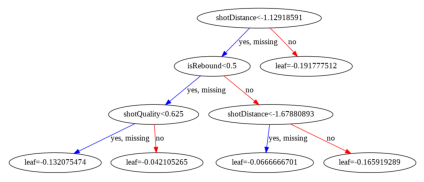

In [55]:
xgb.plot_tree(xgClass,num_trees=0)
plt.tight_layout()

In [56]:
from sklearn.metrics import confusion_matrix

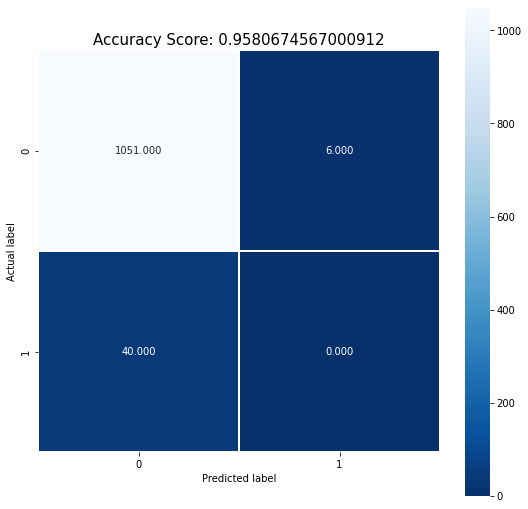

In [57]:
predictions = xgClass.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {xgClass.score(X_test, y_test)}'
plt.title(all_sample_title, size = 15);

In [58]:
lr.intercept_[0]

1.1690212996020282

In [59]:
X.loc

In [60]:
def xGcalc(series, model):
  vec = model.intercept_[0] + ((series.to_numpy() * model.coef_).sum())
  return 1/(1 + np.exp(-vec))

In [61]:
withxG = X.copy()
withxG['xG'] = withxG.apply(lambda x: round(list(zip(*xgClass.predict_proba(X.loc[[x.name]])))[1][0], 2), axis = 1)
withxG = withxG[['xG',]]
withxG

xG
level_0      
3        0.00
20       0.00
29       0.00
43       0.00
48       0.03
...       ...
50832    0.01
50847    0.01
50861    0.08
50866    0.05
50876    0.01

[3656 rows x 1 columns]

In [62]:
withxG['xG'].sum()

128.52999947033823

In [63]:
126/137

0.9197080291970803

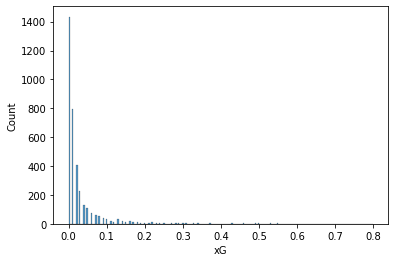

In [64]:
sns.histplot(x='xG', data = withxG)

In [65]:
data = data.join(withxG,how='left',lsuffix = " ", rsuffix = " ")
data = data.join(ratedShots.set_index('index')[['lowHighCount', 'latCount']], how="left", lsuffix="")
data

index    gameDate  ... lowHighCount latCount
0          0  2021-01-23  ...          NaN      NaN
1          1  2021-01-23  ...          NaN      NaN
2          2  2021-01-23  ...          NaN      NaN
3          3  2021-01-23  ...          0.0      0.0
4          4  2021-01-23  ...          NaN      NaN
...      ...         ...  ...          ...      ...
50879  23997  2019-04-14  ...          NaN      NaN
50880  23998  2019-04-14  ...          NaN      NaN
50881  23999  2019-04-14  ...          NaN      NaN
50882  24000  2019-04-14  ...          NaN      NaN
50883  24001  2019-04-14  ...          NaN      NaN

[51021 rows x 49 columns]

# Create Chunks

In [66]:
rdata = ratedShots.set_index('level_0')
rdata = rdata.join(withxG, how='left', lsuffix = "", rsuffix = "")
rdata

index  clock  homeSkaters  ...  lowHighCount latCount    xG
level_0                             ...                             
3            3   1195            5  ...           0.0      0.0  0.00
20          20   1161            5  ...           0.0      0.0  0.00
29          29   1147            5  ...           0.0      1.0  0.00
43          43   1114            5  ...           0.0      0.0  0.00
48          48   1106            5  ...           0.0      0.0  0.03
...        ...    ...          ...  ...           ...      ...   ...
50832    23950    118            5  ...           0.0      0.0  0.01
50847    23965     84            4  ...           0.0      1.0  0.01
50861    23979     42            4  ...           0.0      0.0  0.08
50866    23984     34            4  ...           0.0      0.0  0.05
50876    23994     14            4  ...           0.0      0.0  0.01

[3656 rows x 45 columns]

In [67]:
rdata['passCount'].std()

2.2901451355808295

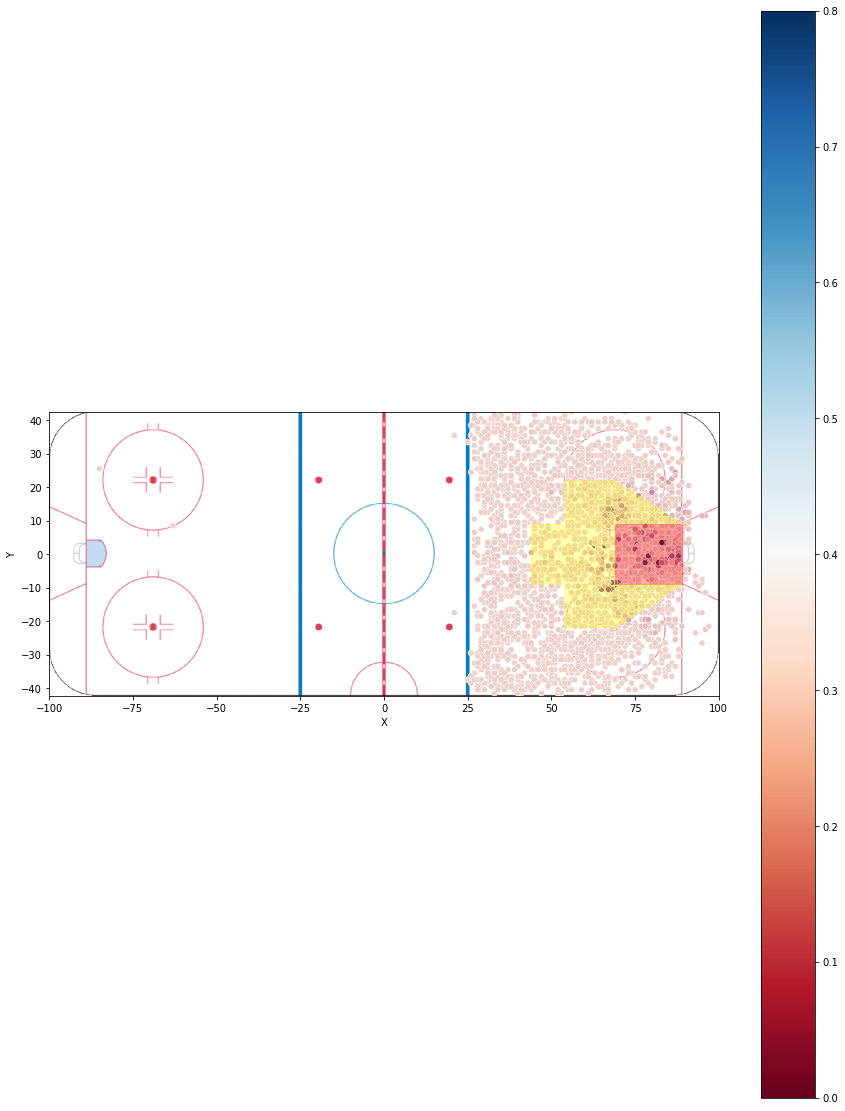

In [68]:
fig, ax = plotIce()
ax = sns.scatterplot(x ='X', y = 'Y', data = rdata, ax = ax, hue = 'xG')
norm = plt.Normalize(rdata['xG'].min(), rdata['xG'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

## Find Power Play Passing

In [69]:
rdata[rdata.shotQuality == 4][['xG']].mean()

xG    0.103668
dtype: float64

In [70]:
# find power play opportunities
PP = rdata[rdata['homeSkaters'] != rdata['awaySkaters']]
PP

index  clock  homeSkaters  ...  lowHighCount latCount    xG
level_0                             ...                             
223        223    737            4  ...           1.0      0.0  0.01
253        253    674            4  ...           0.0      0.0  0.00
306        306    575            4  ...           1.0      1.0  0.00
318        318    555            4  ...           0.0      0.0  0.01
344        344    498            4  ...           0.0      1.0  0.01
...        ...    ...          ...  ...           ...      ...   ...
50832    23950    118            5  ...           0.0      0.0  0.01
50847    23965     84            4  ...           0.0      1.0  0.01
50861    23979     42            4  ...           0.0      0.0  0.08
50866    23984     34            4  ...           0.0      0.0  0.05
50876    23994     14            4  ...           0.0      0.0  0.01

[949 rows x 45 columns]

In [71]:
print(rdata.passCount.mean())
h = PP.groupby("passCount")[['xG']].aggregate(['mean','count']).reset_index()
i = rdata.groupby("passCount")[['xG']].aggregate(['mean','count']).reset_index()
h['xG'][['mean']]

2.057604994324631


mean
0   0.050909
1   0.027615
2   0.022015
3   0.026569
4   0.023118
5   0.019846
6   0.026889
7   0.035682
8   0.022813
9   0.034500
10  0.020000
11  0.009412
12  0.025000
13  0.020000
14  0.012500
15  0.010000
16  0.150000
17  0.000000

In [72]:
rdata.groupby("ozonePassCount")[['xG', "shotQuality"]].aggregate(['mean','count'])

xG       shotQuality      
                    mean count        mean count
ozonePassCount                                  
0.0             0.024866  1714    2.638856  1714
1.0             0.030483   808    2.193069   808
2.0             0.026675   394    1.642132   394
3.0             0.029142   233    1.523605   233
4.0             0.032450   151    1.430464   151
5.0             0.021647    85    1.529412    85
6.0             0.018810    42    1.357143    42
7.0             0.021429    35    1.485714    35
8.0             0.022692    26    1.461538    26
9.0             0.020000    16    1.375000    16
10.0            0.007143     7    1.714286     7
11.0            0.025000     4    1.500000     4
12.0            0.045000     4    1.750000     4
13.0            0.020000     4    1.500000     4
15.0            0.010000     1    2.000000     1

In [73]:
print(PP.passCount.mean())
PP.groupby("lowHighCount")[['xG']].aggregate(['mean', 'count'])

3.3613259668508286


xG      
                  mean count
lowHighCount                
0.0           0.033834   746
1.0           0.013631   157
2.0           0.000000     2

In [74]:
PP.groupby("latCount")[['xG', "shotQuality"]].aggregate(['mean', 'count'])

xG       shotQuality      
              mean count        mean count
latCount                                  
0.0       0.033154   723    2.156293   723
1.0       0.018742   151    1.509934   151
2.0       0.020357    28    1.357143    28
3.0       0.003333     3    1.333333     3

In [75]:
rdata.groupby("passCluster_13.0")[['xG']].aggregate(['median', 'mean', 'count','std'])

xG                          
                 median      mean count       std
passCluster_13.0                                 
0                  0.01  0.035585  3558  0.083317
1                  0.01  0.018554    83  0.034078
2                  0.00  0.028000    10  0.051164
3                  0.01  0.020000     5  0.018708

In [76]:
PP.groupby("passCluster_13.0")[['xG']].aggregate(['mean', 'count','std'])

xG                
                      mean count       std
passCluster_13.0                          
0                 0.039354   851  0.076264
1                 0.018554    83  0.034078
2                 0.028000    10  0.051164
3                 0.020000     5  0.018708

In [77]:
rdata.groupby("lowHighCount")[['xG']].aggregate(['mean', 'count','std'])

xG                
                  mean count       std
lowHighCount                          
0.0           0.028844  3123  0.060803
1.0           0.010227   397  0.024344
2.0           0.005000     4  0.010000

In [130]:
PP[((PP['passCluster_12.0'] >= 1) | (PP['passCluster_14.0'] >= 1))]['xG'].mean()

0.020889679586441917

In [110]:
noReboundPP = PP[PP.isRebound != 1]
noReboundPP

index  clock  homeSkaters  ...  lowHighCount latCount    xG
level_0                             ...                             
3052      3052    872            5  ...           NaN      NaN  0.11
5353      5353     25            5  ...           NaN      NaN  0.02
6119      6119    895            5  ...           NaN      NaN  0.46
9265      9265    718            5  ...           NaN      NaN  0.05
9542      9542    145            4  ...           NaN      NaN  0.02
...        ...    ...          ...  ...           ...      ...   ...
50832    23950    118            5  ...           0.0      0.0  0.01
50847    23965     84            4  ...           0.0      1.0  0.01
50861    23979     42            4  ...           0.0      0.0  0.08
50866    23984     34            4  ...           0.0      0.0  0.05
50876    23994     14            4  ...           0.0      0.0  0.01

[351 rows x 45 columns]

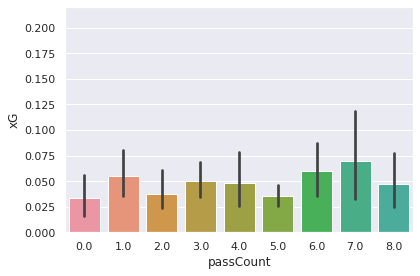

In [111]:
axx = sns.barplot(x='passCount', y = 'xG', data = noReboundPP)
axx.set_xlim(-0.5, 8.5)
plt.tight_layout()

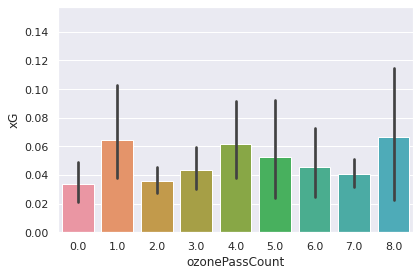

In [112]:
axx = sns.barplot(x='ozonePassCount', y = 'xG', data = noReboundPP)
axx.set_xlim(-0.5, 8.5)
plt.tight_layout()

## Average `xG` based on Cluster

In [82]:
completions = []
attempts = []
for i in range(kmeans.n_clusters):
  tot = len(data[(data[f"passCluster_{i}.0"] > 0) & ((data["event"] == "Play") | (data["event"] == "Incomplete Play"))])
  c = len(data[(data[f"passCluster_{i}.0"] > 0) & ((data["event"] == "Play"))])
  completions.append(round(c/tot, 3))
  attempts.append(tot)

In [125]:
avgxGClusters = []
for i in range(18):
  avgxGClusters.append(round(PP[PP[f'passCluster_{i}.0'] > 0]['xG'].mean(),3))
avgxGdf = pd.DataFrame({'xG': avgxGClusters, 'completionRate': completions, "attempts": attempts,})
avgxGdf

xG  completionRate  attempts
0   0.042           0.614       158
1   0.022           0.924       210
2   0.026           0.786       238
3   0.026           0.918       232
4   0.026           0.830       223
5   0.027           0.932       190
6   0.022           0.899       138
7   0.026           0.809       173
8   0.022           0.748       127
9   0.039           0.731       175
10  0.023           0.938       256
11  0.028           0.506       162
12  0.013           0.903       185
13  0.020           0.877       162
14  0.027           0.919       258
15  0.029           0.730       115
16  0.020           0.963       268
17  0.022           0.861       187

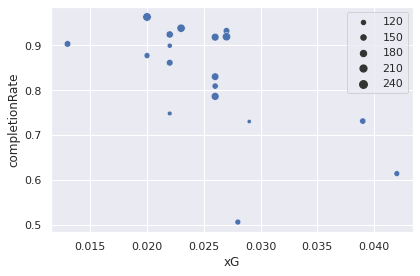

In [84]:
sns.set_theme()
sns.scatterplot(x='xG', y='completionRate', data=avgxGdf, size=attempts,)
plt.tight_layout()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(1, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.annotate(min(avgxGClusters.values())[0],(0,0))
    ax.annotate(max(avgxGClusters.values())[0],(10,0))

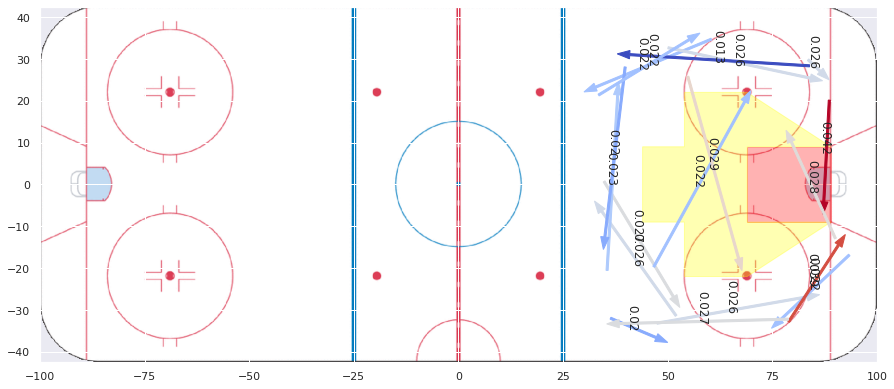

In [126]:
sns.set_style("white")
sns.set_theme("notebook")
from matplotlib import cm
cmap = cm.get_cmap('coolwarm', 56)
cmap(0.034)
fig, ax = plotIce()
for i in range(kmeansPP.n_clusters):
  currentC = kmeansPP.cluster_centers_[i]
  startX, startY, endX, endY = currentC[0], currentC[1], currentC[2], currentC[3]
  minmaxValue = (avgxGClusters[i]- min(avgxGClusters)) / (max(avgxGClusters) - min(avgxGClusters))
  color = cmap(minmaxValue)
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                  head_width=2, linestyle = "-", color = color, width=0.5, alpha = 1,)
  midpointX = ((startX + endX) / 2) - 2
  midpointY = (startY + endY) / 2
  ax.annotate(avgxGClusters[i], (midpointX, midpointY), rotation = -90)
colors = cmap(np.arange(cmap.N))
# ax.imshow([colors], extent=[0, 10, 0, 1])

In [127]:
avgxGClusters

[0.042,
 0.022,
 0.026,
 0.026,
 0.026,
 0.027,
 0.022,
 0.026,
 0.022,
 0.039,
 0.023,
 0.028,
 0.013,
 0.02,
 0.027,
 0.029,
 0.02,
 0.022]

## Plot Different passes

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


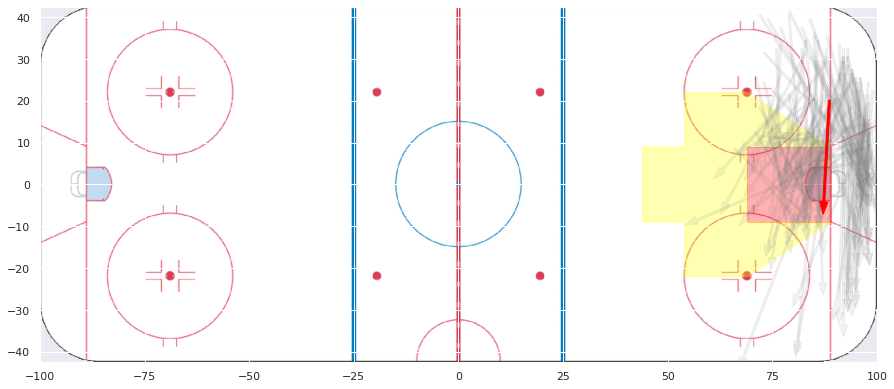

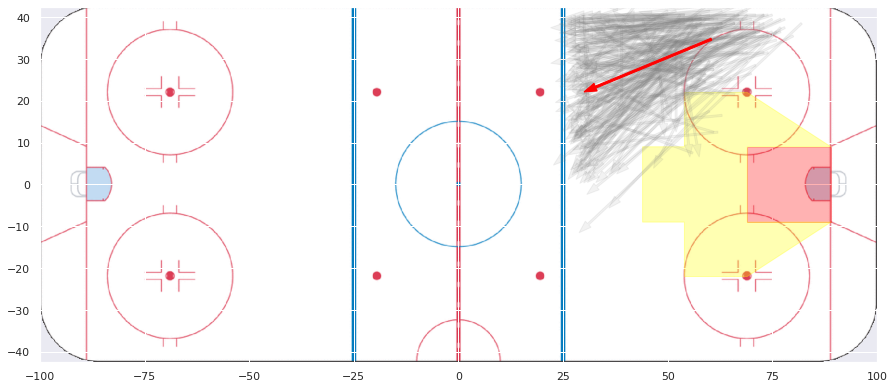

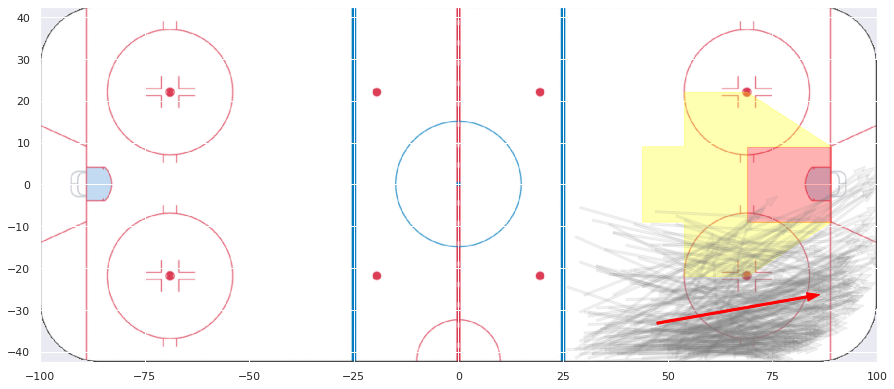

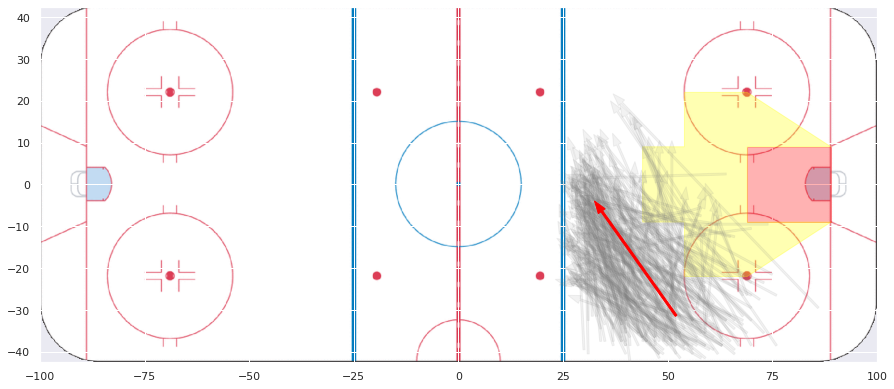

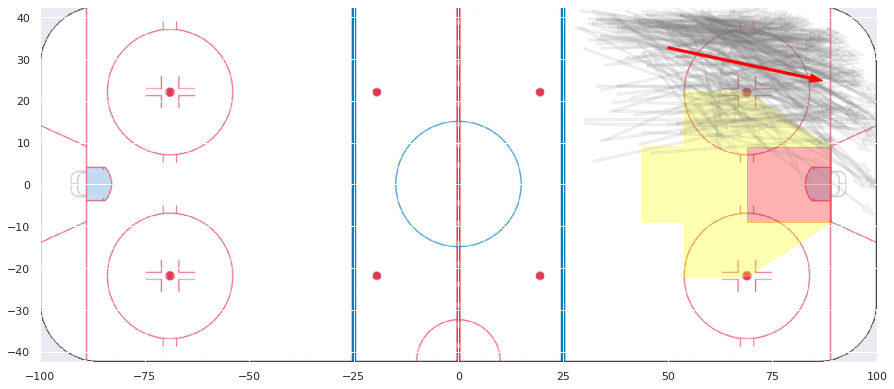

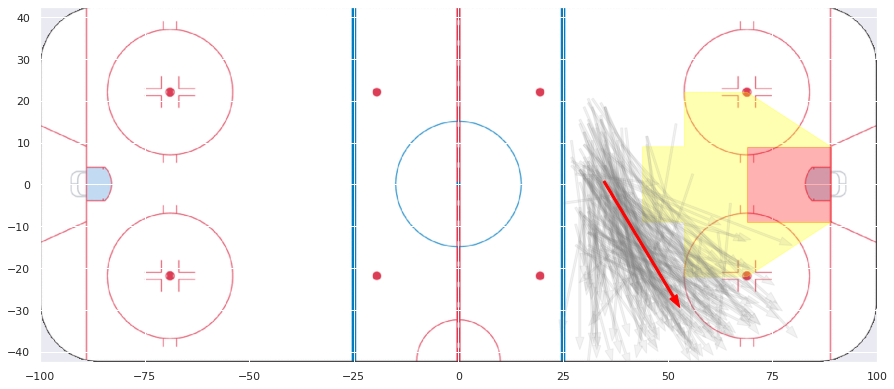

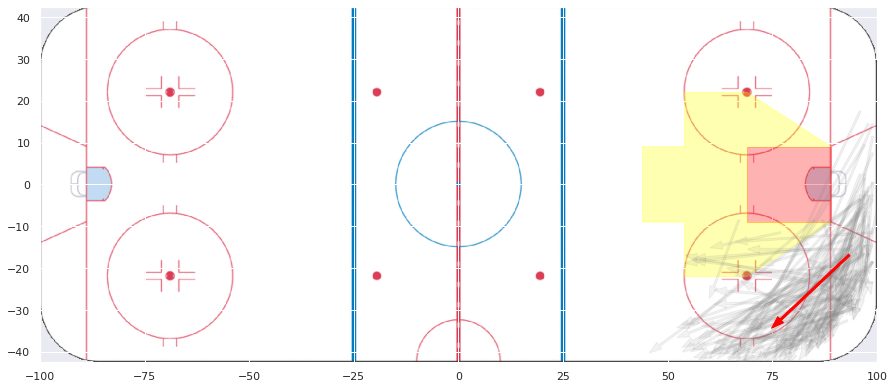

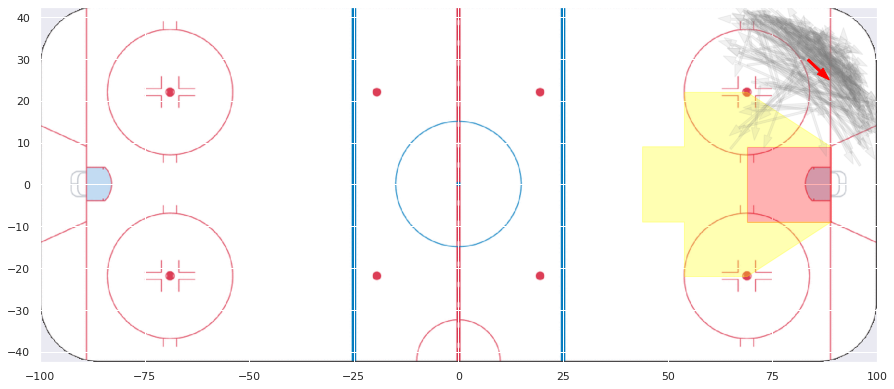

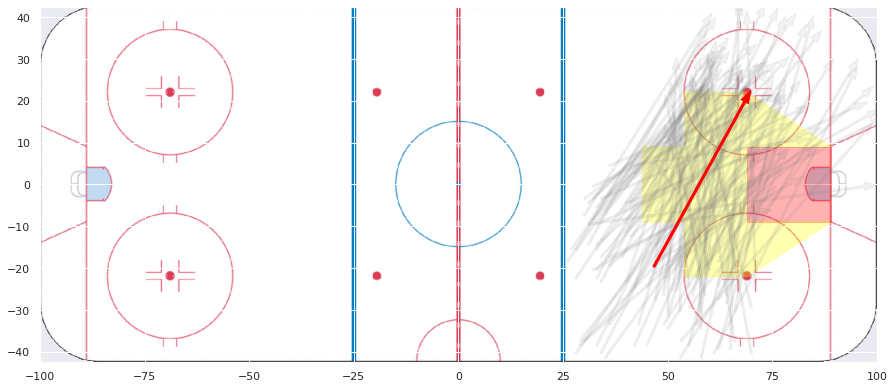

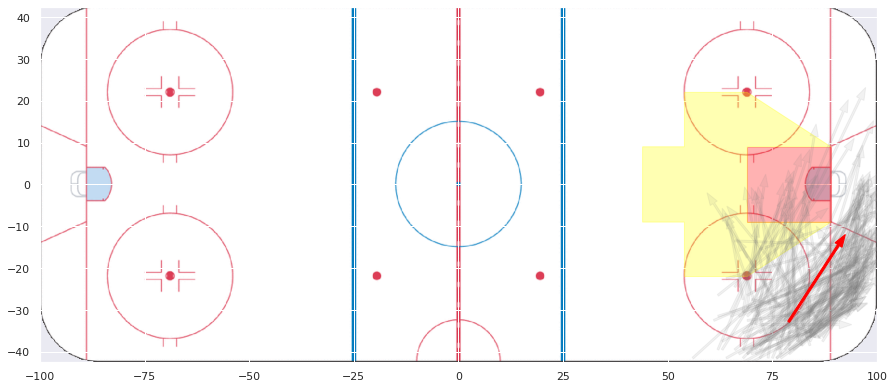

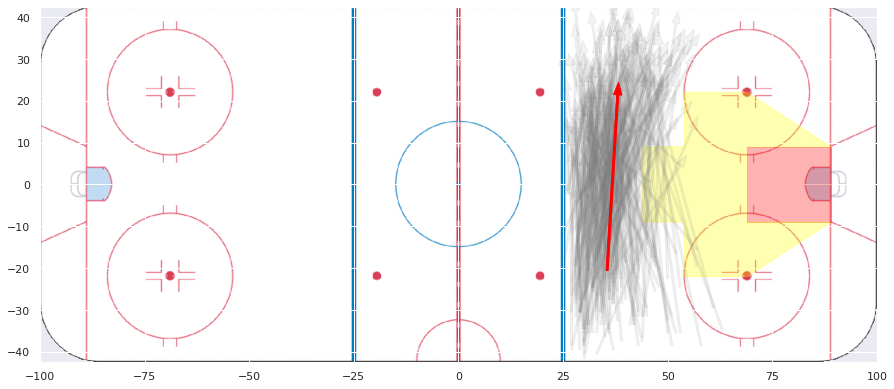

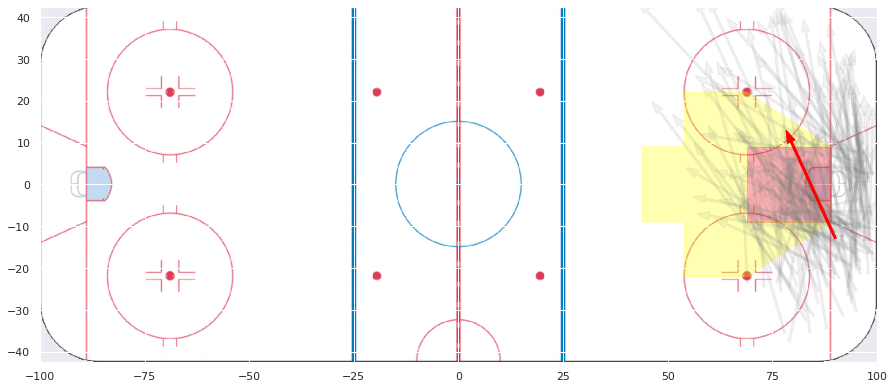

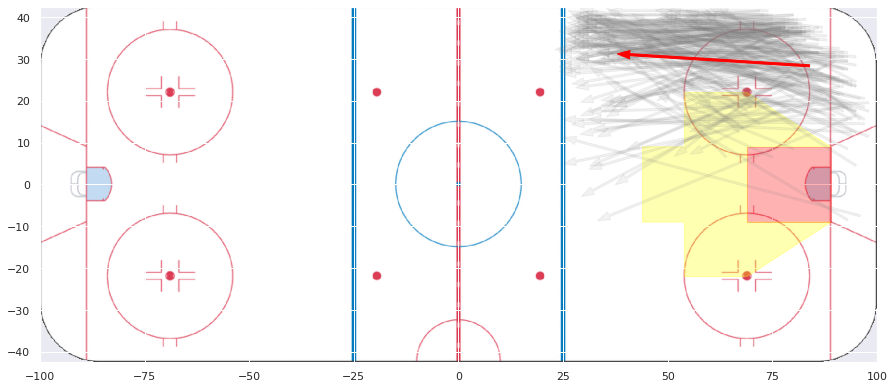

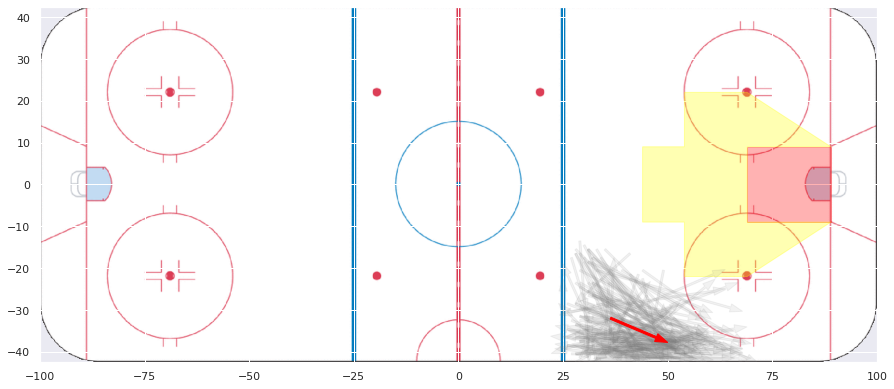

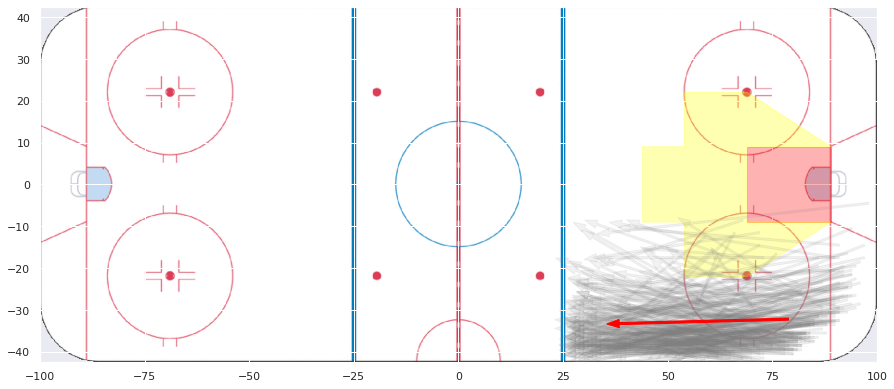

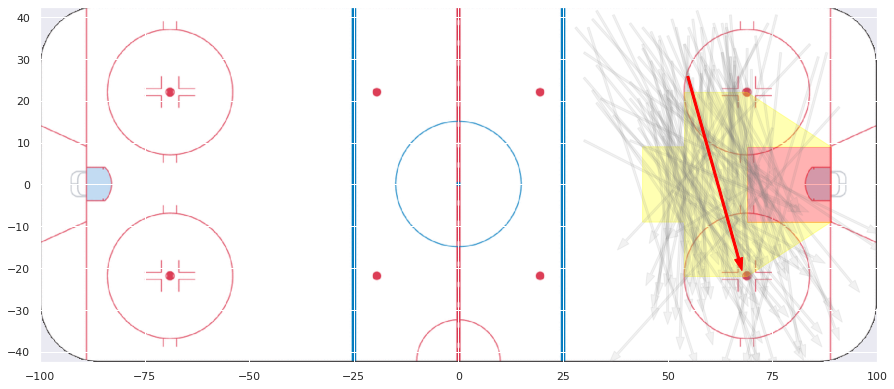

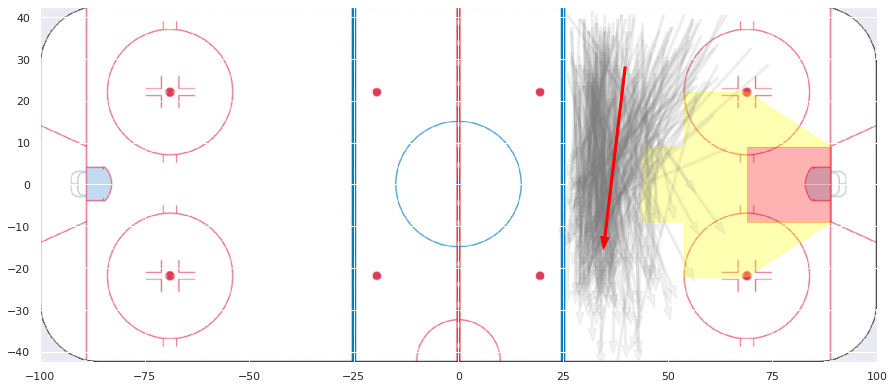

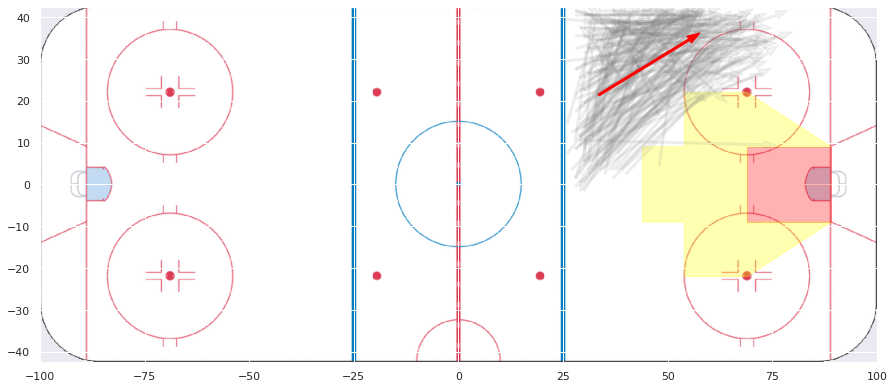

In [87]:
for i in range(kmeansPP.n_clusters):
  print(i)
  fig, ax = plotIce()
  currentC = kmeansPP.cluster_centers_[i]
  for index, row in data[data[f'passCluster_{i}.0'] > 0].iterrows(): 
    startX, startY, endX, endY = row['X'], row['Y'], row['X2'], row['Y2']
    ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                  head_width=2, linestyle = "-", color = "grey", width=0.5, alpha = 0.1,)
  startX, startY, endX, endY = currentC[0], currentC[1], currentC[2], currentC[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                  head_width=2, linestyle = "-", color = "red", width=0.5, alpha = 1,)

In [88]:
kmeans.cluster_centers_[0][1]

17.417142857142952

Expected goals off of any shot with a pass

In [89]:
swP = rdata[rdata.passCount > 0]
swP.groupby("lowHighCount")[['xG']].aggregate(['mean', 'count','std'])

xG                
                  mean count       std
lowHighCount                          
0.0           0.027840  2245  0.064119
1.0           0.010229   393  0.024457
2.0           0.005000     4  0.010000

## Visualizations

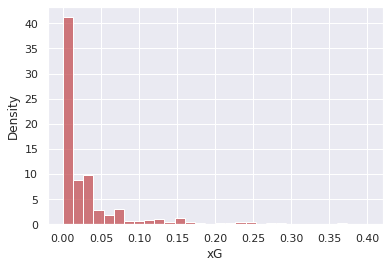

In [90]:
sns.histplot(x = 'xG', data = PP, color = "r", stat = "density", bins=30, binrange=(0,0.4))

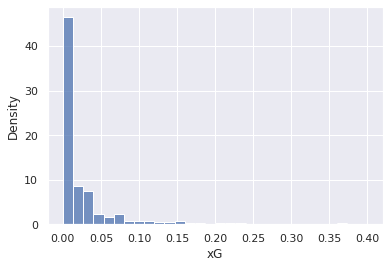

In [91]:
sns.histplot(x = 'xG', data = rdata, stat = "density", bins=30, binrange=(0,0.4))

(-0.5, 11.5)

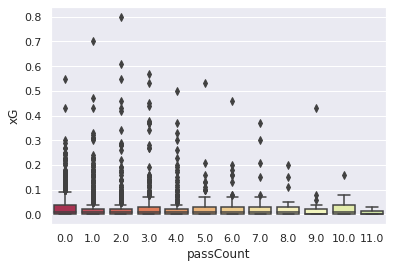

In [92]:
axx = sns.boxplot(x = 'passCount', y = 'xG', data= rdata, palette="Spectral")
axx.set_xlim((-.5,11.5))

(-0.5, 11.5)

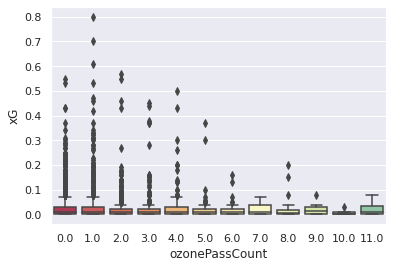

In [93]:
axx = sns.boxplot(x = 'ozonePassCount', y = 'xG', data= rdata, palette="Spectral")
axx.set_xlim((-.5,11.5))

(-0.5, 11.5)

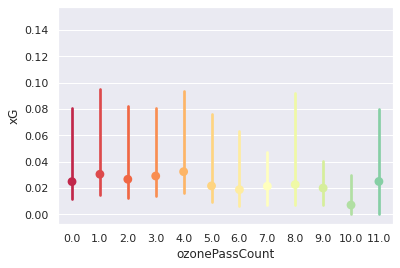

In [94]:
axx = sns.pointplot(x = 'ozonePassCount', y = 'xG', data= rdata, palette="Spectral", units='xG')
axx.set_xlim((-.5,11.5))

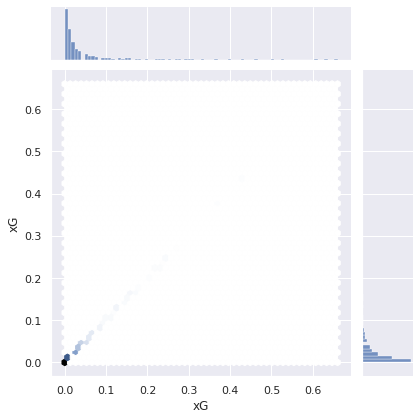

In [95]:
sns.jointplot(x = PP['xG'], y = rdata['xG'], kind = "hex")

In [96]:
data[data.event == "Play"]

index    gameDate                       home  ...  xG  lowHighCount latCount
8          8  2021-01-23        Minnesota Whitecaps  ... NaN           NaN      NaN
9          9  2021-01-23        Minnesota Whitecaps  ... NaN           NaN      NaN
11        11  2021-01-23        Minnesota Whitecaps  ... NaN           NaN      NaN
17        17  2021-01-23        Minnesota Whitecaps  ... NaN           NaN      NaN
22        22  2021-01-23        Minnesota Whitecaps  ... NaN           0.0      0.0
...      ...         ...                        ...  ...  ..           ...      ...
50873  23991  2019-04-14  Olympic (Women) - Finland  ... NaN           NaN      NaN
50874  23992  2019-04-14  Olympic (Women) - Finland  ... NaN           NaN      NaN
50879  23997  2019-04-14  Olympic (Women) - Finland  ... NaN           NaN      NaN
50880  23998  2019-04-14  Olympic (Women) - Finland  ... NaN           NaN      NaN
50881  23999  2019-04-14  Olympic (Women) - Finland  ... NaN           NaN      NaN

[14673 rows x 49 columns]

In [97]:
print(rdata[rdata['lowHighCount'] > 0]['xG'].mean())
rdata[rdata['latCount'] > 0]['xG'].mean()

0.010174563461148233


0.018674698609664257

In [98]:
print(84 / (84 + 654))
324 / (324 + 1186)

0.11382113821138211


0.21456953642384105

In [99]:
from scipy import stats

In [100]:
rdata[rdata['latCount'] > 0]['xG'].mean()

0.018674698609664257

In [101]:
stats.ttest_ind(rdata[rdata['lowHighCount'] > 0]['xG'], rdata[rdata['latCount'] > 0]['xG'])

Ttest_indResult(statistic=-3.894869989092741, pvalue=0.00010554730766601244)

In [102]:
stats.ttest_ind(PP[PP['lowHighCount'] > 0]['xG'], PP[PP['latCount'] > 0]['xG'])

Ttest_indResult(statistic=-1.3877321455526992, pvalue=0.1661300779706926)

In [103]:
lowLat = PP[(PP['lowHighCount'] >= 1) | (PP['latCount'] >= 1)]
lowLat

index  clock  homeSkaters  ...  lowHighCount latCount    xG
level_0                             ...                             
223        223    737            4  ...           1.0      0.0  0.01
306        306    575            4  ...           1.0      1.0  0.00
344        344    498            4  ...           0.0      1.0  0.01
688        688    921            4  ...           1.0      1.0  0.00
711        711    860            4  ...           1.0      1.0  0.00
...        ...    ...          ...  ...           ...      ...   ...
48365    21483    855            5  ...           1.0      1.0  0.01
49872    22990   1160            4  ...           1.0      0.0  0.01
50571    23689    747            3  ...           0.0      1.0  0.08
50584    23702    717            3  ...           1.0      0.0  0.03
50847    23965     84            4  ...           0.0      1.0  0.01

[271 rows x 45 columns]

In [104]:
seperateChunks(data)

Staring


array([[list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        ...,
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
       [array([0, '2021-01-23', 'Minnesota Whitecaps', 'Boston Pride', 1, '20:00',
       5, 5, 0, 0, 'Boston Pride', 'Jillian Dempsey', 'Faceoff Win', 0,
       0.5, 'Backhand', nan, nan, nan, 'Stephanie Anderson', nan, nan, 0,
       0, nan, nan, nan, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, nan, nan, nan, nan, nan, nan], dtype=object),
        array([1, '2021-01-23', 'Minnesota Whitecaps', 'Boston Pride', 1, '19:58',
       5, 5, 0, 0, 'Boston Pride', 'McKenna Brand', 'Puck Recovery',

In [105]:
chunks = data.reset_index().set_index(['chunk', 'chunkIdx'])
chunks

level_0  index    gameDate  ...   xG lowHighCount  latCount
chunk   chunkIdx                              ...                            
1.0     0.0             0      0  2021-01-23  ...  NaN          NaN       NaN
        1.0             1      1  2021-01-23  ...  NaN          NaN       NaN
        2.0             2      2  2021-01-23  ...  NaN          NaN       NaN
        3.0             3      3  2021-01-23  ...  0.0          0.0       0.0
2.0     0.0             4      4  2021-01-23  ...  NaN          NaN       NaN
...                   ...    ...         ...  ...  ...          ...       ...
13178.0 2.0         50879  23997  2019-04-14  ...  NaN          NaN       NaN
        3.0         50880  23998  2019-04-14  ...  NaN          NaN       NaN
        4.0         50881  23999  2019-04-14  ...  NaN          NaN       NaN
        5.0         50882  24000  2019-04-14  ...  NaN          NaN       NaN
13179.0 0.0         50883  24001  2019-04-14  ...  NaN          NaN       NaN

[51021 rows x 50 columns]

In [106]:

passIndex = np.array(lowLat.index)
eventAfter = passIndex + 1
# data.iloc[eventAfter].groupby("event").count()[['home']]

chunks_withLatLowIdx = np.unique(np.array(list(zip(*chunks.iloc[passIndex].index))[0]))
# create pandas index slice and access all chunks that contain lat low pass
idx = pd.IndexSlice
chunks_withLatLow = chunks.loc[idx[chunks_withLatLowIdx],:]
chunks_withLatLow

level_0  index    gameDate  ...    xG lowHighCount  latCount
chunk   chunkIdx                              ...                             
58.0    0.0           211    211  2021-01-23  ...   NaN          NaN       NaN
        1.0           212    212  2021-01-23  ...   NaN          NaN       NaN
        2.0           213    213  2021-01-23  ...   NaN          NaN       NaN
        3.0           214    214  2021-01-23  ...   NaN          NaN       NaN
        4.0           215    215  2021-01-23  ...   NaN          NaN       NaN
...                   ...    ...         ...  ...   ...          ...       ...
13139.0 33.0        50707  23825  2019-04-14  ...   NaN          NaN       NaN
        34.0        50708  23826  2019-04-14  ...   NaN          NaN       NaN
        35.0        50709  23827  2019-04-14  ...  0.03          NaN       NaN
        36.0        50710  23828  2019-04-14  ...   NaN          NaN       NaN
        37.0        50711  23829  2019-04-14  ...   NaN          NaN       NaN

[1694 rows x 50 columns]

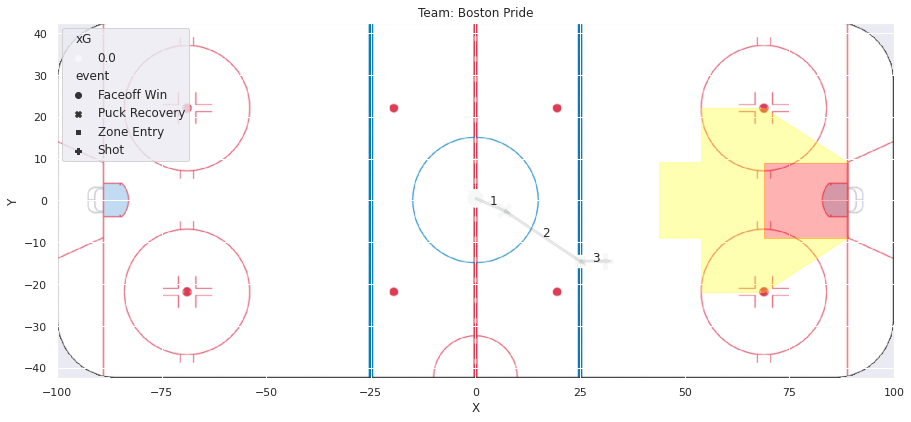

In [107]:
fig, ax = plotIce()
mapPassEvents(chunks.loc[1], fig, ax)

ValueError: ignored

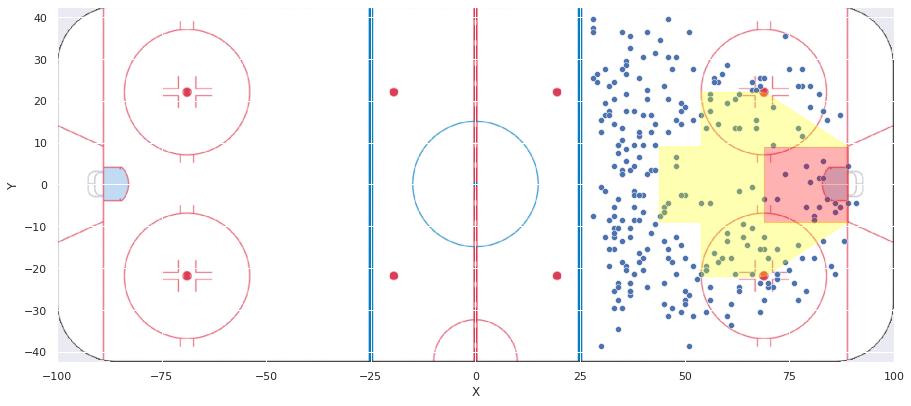

In [108]:
fig, ax = plotIce()
sns.scatterplot(x= 'X', y = 'Y', data = lowLat, ax = ax)
sns.scatterplot(x= 'X2', y = 'Y2', data = lowLat, ax = ax, color = 'red')

In [ ]:
n = 890
fig, ax = plotIce()
mapPassEvents(chunks.loc[n], fig, ax)
chunks.loc[n]

In [ ]:
for i in chunks_withLatLowIdx[:30]:
  fig, ax = plotIce()
  mapPassEvents(chunks.loc[i], fig, ax)

# Plot Passes

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# all passes
Xpasses = data[(data.event == "Play") & (data.X >= 25) & (data.X2 >=25)][['X', 'Y', 'X2', 'Y2']]
kmeans = KMeans(n_clusters=18, init='k-means++',)
kmeans.fit(Xpasses)
graphX = kmeans.cluster_centers_
fig, ax = plotIce()
count = 0
for i in graphX: 
  startX, startY, endX, endY = i[0], i[1], i[2], i[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                head_width=2, linestyle = "-", color = "grey", width=0.5, alpha = 0.5,)
  midpointX = (startX + endX) / 2
  midpointY = (startY + endY) / 2
  ax.annotate(kmeans.labels_[count], (midpointX, midpointY))
  count +=1

In [ ]:
len(kmeans.labels_)

In [ ]:
# powerplay passes
Xpasses = data[(data.event == "Play") & (data.X >= 25) & (data.X2 >=25) & (data.homeSkaters != data.awaySkaters)][['X', 'Y', 'X2', 'Y2']]
kmeans = KMeans(n_clusters=36, init='k-means++')
kmeans.fit(Xpasses)
graphX = kmeans.cluster_centers_
fig, ax = plotIce()
for i in graphX: 
  startX, startY, endX, endY = i[0], i[1], i[2], i[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                head_width=2, linestyle = "-", color = "grey", width=0.5, alpha = 0.5,)
  sns.scatterplot(x=[35, 68], y = [0,-30 ], ax=ax)

In [ ]:
graphX

In [ ]:
# powerplay passes for erie
Xpasses = erie[(erie.event == "Play") & (erie.X >= 25) & (erie.X2 >=25) & (erie.homeSkaters != erie.awaySkaters)][['X', 'Y', 'X2', 'Y2']]
kmeans = KMeans(n_clusters=36, init='k-means++')
kmeans.fit(Xpasses)
graphX = kmeans.cluster_centers_
fig, ax = plotIce()
for i in graphX: 
  startX, startY, endX, endY = i[0], i[1], i[2], i[3]
  ax.arrow(startX, startY, (endX - startX), (endY - startY), 
                head_width=2, linestyle = "-", color = "blue", width=0.5, alpha = 0.3,)
# powerplay passes
# Xpasses = data[(data.event == "Play") & (data.X >= 25) & (data.X2 >=25) & (data.homeSkaters != data.awaySkaters)][['X', 'Y', 'X2', 'Y2']]
# kmeans = KMeans(n_clusters=64, init='k-means++')
# kmeans.fit(Xpasses)
# graphX = kmeans.cluster_centers_
# for i in graphX: 
#   startX, startY, endX, endY = i[0], i[1], i[2], i[3]
#   ax.arrow(startX, startY, (endX - startX), (endY - startY), 
#                 head_width=2, linestyle = "-", color = "pink", width=0.5, alpha = 0.6,)

In [ ]:
def distance(X,Y):
  return round(np.sqrt((89-X)**2 + (0 - Y)**2), 2)

In [ ]:
import math
def shotAngle(X,Y):
  x0 = 89 - X
  return math.degrees(math.atan2(Y, x0))

In [ ]:
def timeDiff(clock, series, df):
  idx = series.name
  if idx == 0:
    return 0
  return df.loc[idx - 1, 'clock'] - clock

In [ ]:
data

In [ ]:
passIdx = (data['event'] == "Play") | (data['event'] == "Incomplete Play")
data['passDistance'] = data[passIdx].apply(lambda x: np.sqrt((x['X2'] - x['X'])**2 + (x['Y2'] - x['Y'])**2), axis=1)
data

In [ ]:
xGData = data.copy()
xGData = xGData.drop(['gameDate', 'home', 'away', 'period', 'player', "player2", "X2", "Y2", "homeGoals", "awayGoals"], axis = 1)
xGData['shotDistance'] = xGData[(xGData['event'] == "Shot") | (xGData['event'] == "Goal")].apply(lambda x: distance(x["X"], x['Y']), axis = 1)
xGData['shotAngle'] = xGData[(xGData['event'] == "Shot") | (xGData['event'] == "Goal")].apply(lambda x: shotAngle(x["X"], x['Y']), axis = 1)
xGData['isGoal'] = xGData['event'].apply(lambda x: 1 if (x == "Goal") else 0)
xGData['clock'] = xGData['clock'].apply(timetoSecs)
xGData['timeDiff'] = xGData.apply(lambda x: timeDiff(x['clock'], x, xGData), axis = 1)
xGData # [(xGData['event'] == "Shot") | (xGData['event'] == "Goal")]

## Chunks for passes and goals

In [ ]:
def seperatePassShotChunks(df):
  print("Staring")
  sequences = []
  seq = []
  team = df.iloc[0]["team"]

  # establish empty chunkCount column

  df['chunk'], df['chunkIdx'] = np.NaN, np.NaN
  maxlen = 0
  chunkCount = 0
  itercount = 0
  for index, rows in df.iterrows():
    if ((rows["event"] == "Shot") | (rows['event'] == "Goal")): 
      sequences.append(seq)
      df.loc[index,'chunk'] = chunkCount
      df.loc[index,'chunkIdx'] = itercount
      chunkCount += 1
      itercount = 0
      seq = []
      continue
    if ((team != rows["team"])):
      # print("row is different team")
      sequences.append(seq)
      chunkCount += 1
      itercount = 0
      seq = []
    if len(seq) == 0:
      # print("establish new team")
      team = rows["team"]
    if team == rows["team"]:
      # print("row is same team")
      seq.append(rows.to_numpy())
    df.loc[index,'chunk'] = chunkCount
    df.loc[index,'chunkIdx'] = itercount
    itercount += 1
  return toArray(sequences) # for LTSM

In [ ]:
passShot = xGData[(xGData['event'] == "Shot") | (xGData['event'] == "Goal") | (xGData['event'] == "Play") | (xGData['event'] == "Incomplete Play")]
seperatePassShotChunks(passShot)

In [ ]:
# chunks consisting of only passes and shots
passchunks = passShot.reset_index().set_index(['chunk', 'chunkIdx'])
passchunks

## Score Shots for quality of prior passes

In [ ]:
np.unique(np.array(list(zip(*passchunks.index))[0]))

In [ ]:
def countPassTypes(chunk):
  chas = np.unique(np.array(list(zip(*chunk.index))[0]))
  for index in chas:
    current = chunk.loc[index]
    current = current.fillna(0)

    try:
      shotIdx = int(current.iloc[-1].name)
    except ValueError:
      shotIdx = current.iloc[-1].name
    
    
    realIdx = current.loc[shotIdx, "index"]
    if (data.loc[realIdx, "event"] == "Shot"):
      passchunks.loc[(index, shotIdx), 'isRebound'] = 1
    if current.loc[shotIdx, "event"] != "Shot":
      continue
    if len(current) <= 3:
      subtract = shotIdx - (len(current) - 1)
    else:
      subtract = shotIdx - 3
    # print(current[subtract:shotIdx]['isLowHigh'])
    # find number of low high pass
    passchunks.loc[(index, shotIdx), 'passCount'] = len(current[current.event == "Play"])
    passchunks.loc[(index, shotIdx), 'ozonePassCount'] = len(current[(current.event == "Play") & (current.X >= 25) & (current.X >= 25)])
    passchunks.loc[(index, shotIdx), 'lowHighCount'] = current[subtract:shotIdx]['isLowHigh'].sum()
    passchunks.loc[(index, shotIdx), 'latCount'] = current[subtract:shotIdx]['isLat'].sum()
    # print(passchunks.loc[(index, shotIdx), 'latCount'])

    # if (current['isLowHigh'].sum() > 0) | (current['isLat'].sum() > 0):
    #   print(index, current['isLat'].sum(), current['isLowHigh'].sum())
  

In [ ]:
countPassTypes(passchunks)
# passchunks.loc[(595,5), 'latCount'] = "hate"
passchunks.loc[(593, 0), "index"]

In [ ]:
passchunks[passchunks.ozonePassCount > 0]

In [ ]:
data[420:430]

### Rate shots

In [ ]:
ratedShots = passchunks[(passchunks.loc[(slice(None),), "event"] == "Goal") | (passchunks.loc[(slice(None),), "event"] == "Shot")]
ratedShots[ratedShots.isRebound == 1]

In [ ]:
eSOG = erie.loc[erie['d2'] == "On Net"]
erie['shotQuality'] = eSOG.apply(lambda x: isHighDanger(x['X'],x['Y'], x.name, erie), axis = 1)
eSOG = erie.loc[(erie['event'] == "Shot") & (erie['d2'] == "On Net")]
eS = erie.loc[erie['event'] == "Shot"]
eSOGG = erie.loc[(erie['d2'] == "On Net")]
eG = erie.loc[(erie['event'] == "Goal")]
# eHDSOG = eSOG[eSOG['shotQuality'] == 3]
eG

In [ ]:
#score all Corsi events
nwhl['shotQuality'] = nwhl.loc[(nwhl['event'] == "Shot") | (nwhl['event'] == "Goal")].apply(lambda x: isHighDanger(x['X'],x['Y'], x.name, nwhl), axis = 1)

In [ ]:
# create indexes for low high
lowHighStart = (passes['X'] >= 69)
lowHighEnd = (passes['X2'] <= 44) & (passes['X2'] >= 24)
lowHigh = passes[lowHighStart & lowHighEnd]
# plot to confirm location
fig, ax = plotIce()
sns.scatterplot(x= 'X', y = 'Y', data = lowHigh, ax = ax)
sns.scatterplot(x= 'X2', y = 'Y2', data = lowHigh, ax = ax, color = 'red')
# display data frame
lowHigh

In [ ]:
## find all pass attempts (labled as Play)
passes = PP[(PP.event == "Play") | (PP.event == "Incomplete Play")]
# define a "lateral" pass
lateralStart = ((passes['X'] >= 54) & (passes['Y'] <= -22) | (passes['Y'] >= 22)) # check if lateral pass will start in right location
lateralEnd = ((passes['X2'] >= 54) & (passes['Y2'] <= -22) | (passes['Y2'] >= 22)) # check if lateral pass will end in right location
lateral = passes[lateralStart & lateralEnd & (passes['X'] >= 54) & (passes['X2'] >= 54)] # data frame with just lateral passes
# graph start and end location of lateral passes to confirm
fig, ax = plotIce()
sns.scatterplot(x= 'X', y = 'Y', data = lateral, ax = ax)
sns.scatterplot(x= 'X2', y = 'Y2', data = lateral, ax = ax, color = 'red')
# display data frame
lateral

# Exploring Data


# Zone Entries

In [ ]:
eZoneEntries = erie[erie['event'] == 'Zone Entry'].reset_index()
eZoneEntries.head()

In [ ]:
erie[((erie.homeSkaters <= 4) | (erie.awaySkaters <= 4)) & (erie.event == "Shot") & (erie.d2 == "On Net")]

# Scoring Chance Regions

# Passing patterns

In [ ]:
ePass = erie.loc[(erie['event'] == "Play") | (erie['event'] == "Incomplete Play")]
ePass

In [ ]:
fig, ax = plotIce()
colors = {
      'Incomplete Play': 'red',
      'Play': 'blue'
  }
tofP = {
    'Direct': '-',
    'Indirect': '-.'
}

for index, play in ePass.iterrows():
  cColor = colors[play['event']]
  ctype = tofP[play['d1']]
  ax.arrow(play['X'], play['Y'], (play['X2'] - play['X']), (play['Y2'] - play['Y']), head_width=3, linestyle = ctype, color = cColor, width=1, alpha = 0.3,)

### Identifying Plays

In [ ]:
firstPlay = chunks[chunks.index.get_level_values('chunkIdx') == 1]#.reset_index('chunkIdx')
lastPlay = chunks[np.roll(chunks.index.get_level_values('chunkIdx') == 1, -1)]#.reset_index('chunkIdx')
h = lastPlay.reset_index(['chunk', 'chunkIdx'])
h['chunkIdx'] = 2
lastPlay = h.set_index(['chunk', 'chunkIdx'])

In [ ]:
a = np.array(list(zip(*chunks[(chunks['awaySkaters'] <= 4) | (chunks['homeSkaters'] <= 4)].index))[0])
ppI = np.unique(a)
ppI[20:30]

In [ ]:
type(erie.groupby(["player","event"]).count())

In [ ]:
firstLastPlay = pd.concat([firstPlay, lastPlay], axis = 0,).sort_index() #.reset_index().#.set_index(['chunk', 'chunkIdx'])
firstLastPlay

#### Breakouts

In [ ]:
index1 = firstLastPlay.loc[(slice(None), 1), "X"] <= -24
index2 = firstLastPlay.loc[(slice(None), 2), "X"] >= -24
a1 = list(zip(*firstLastPlay.loc[(slice(None), 1),:][index1].index))[0]
b1 = list(zip(*firstLastPlay.loc[(slice(None), 2),:][index2].index))[0]
breakoutI = list(set(a1).intersection(b1))
breakoutI.sort()
breakouts = chunks.loc[breakoutI,:]
breakouts

In [ ]:
count = 80
for i in breakoutI:
  fig, ax = plotIce()
  mapPassEvents(breakouts.loc[i], fig, ax)
  count += 1
  if count == 90:
    break

In [ ]:
h = lastPlay.reset_index(['chunk', 'chunkIdx'])
h['chunkIdx'] = 2
h.set_index(['chunk', 'chunkIdx'])